In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [3]:
from joblib import Memory

In [4]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [5]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [6]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [7]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [8]:
def get_traj_ids(base_dir):
    ids = []
    k = 0
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            if len(glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.up")) > 0:
                ids.append(k)
            k += 1
    return np.array(ids)


def get_weights(weights, N, k, ids):
    sampled_w = np.concatenate(weights[:, -N::k])
    # set weight for cis/trans to be the same
    sampled_w = np.repeat(sampled_w, 2)
    return sampled_w[ids]


def load_cv(basename):
    arrays = []
    for file in sorted(glob.glob(f"{basename}_??.npy")):
        arrays.append(np.load(file))
    return np.concatenate(arrays)


def load_all(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    weights = np.load(f"{data_dir}/mbar_weights.npy")
    ids = get_traj_ids(base_dir)
    N = 32000
    k = 1000
    sample_w = get_weights(weights, N, k, ids)

    fs_qtots = load_cv(f"{data_dir}/fs_qtots")
    q_gs_all = load_cv(f"{data_dir}/q_gs_all")
    q_gs = load_cv(f"{data_dir}/q_gs")
    q_fs_all = load_cv(f"{data_dir}/q_fs_all")
    q_fs = load_cv(f"{data_dir}/q_fs")
    q_core = load_cv(f"{data_dir}/q_core")
    omegas = load_cv(f"{data_dir}/omegas")

    c_green = fs_qtots[:, 5] - fs_qtots[:, 4]
    c_blue = fs_qtots[:, 7] - fs_qtots[:, 6]
    c_orange = fs_qtots[:, 3] - fs_qtots[:, 2]
    c_0 = fs_qtots[:, 1] - fs_qtots[:, 0]
    n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)

    cvs = dict(
        blue=c_blue,
        green=c_green,
        orange=c_orange,
        c0=c_0,
        q_gs_all=q_gs_all,
        q_fs_all=q_fs_all,
        q_gs=q_gs,
        q_fs=q_fs,
        q_core=q_core,
        n_cis=n_cis,
        q_diff=q_gs - q_fs,
    )
    return cvs, sample_w

In [9]:
home_dir = "/project/dinner/scguo/kaiB"

In [10]:
cvs_all_ts, weights_all_ts = [], []
qp_all_ts = []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp_all_ts.append(dill.load(f)[(qlag, qmem)])

In [11]:
qm_all_ts = []
for t in [87, 89, 91]:
    with open(f"{home_dir}/dga/new_{t}/data/qm_gs2fs.pkl", mode="rb") as f:
        qm_all_ts.append(dill.load(f)[(qlag, qmem)])

In [12]:
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    c0=r"$\alpha2_{\mathrm{fs}}\longleftrightarrow\beta3_{\mathrm{gs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{gs, C}}-Q_{\mathrm{fs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1, 1.3),
    green=(-1.3, 1),
    orange=(-1.3, 1),
    c0=(-1, 1.3),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

In [13]:
def bin_inds(q, qstep=0.05, low=0, hi=1, skip=1):
    q_arr = np.concatenate(q)[::skip]
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [14]:
def kdesum1d(
    x,
    w,
    *,
    xmin=None,
    xmax=None,
    xstd=None,
    nx=100,
    cut=4.0,
):
    """Compute a 1D kernel density estimate.

    This function histograms the data, then uses a Gaussian filter to
    approximate a kernel density estimate with a Gaussian kernel.

    Parameters
    ----------
    x : ndarray or list/tuple of ndarray
        Coordinates of each frame.
    w : ndarray or list/tuple of ndarray
        Weight or value of each frame. The output is the sum of these
        values in each bin, after smoothing.
    xmin, xmax : float, optional
        Limits of kernel density estimate. If None, takes the min/max
        of the data along the coordinate.
    xstd : float, optional
        Standard deviation of the Gaussian filter. If None, these are
        set to (xmax - xmin) / nx. Increase this to smooth the results more.
    nx : int, optional
        Number of bins in each dimension. This should be set as high as
        reasonable, since xstd takes care of the smoothing.
    cut : float, optional
        Number of standard deviations at which to truncate the Gaussian
        filter. The default, 4, usually doesn't need to be changed.

    Returns
    -------
    kde : (nx,) ndarray
        Kernel density estimate, given as bins.
    xedges : (nx+1,) ndarray
        Bin edges along the x dimension.

    """

    # flatten input to 1D arrays
    x = _flatten(x)
    w = _flatten(w)

    # limits
    _xmin = np.min(x)
    _xmax = np.max(x)
    if xmin is None:
        xmin = _xmin
    if xmax is None:
        xmax = _xmax

    # separation between grid points
    xsep = (xmax - xmin) / nx

    # number of grid points to pad the boundaries,
    # since the Gaussian filter extends beyond the boundaries
    # usually overestimates the padding, but whatever
    ax = max(0, int(np.ceil((xmin - _xmin) / xsep + 1e-6)))
    bx = max(0, int(np.ceil((_xmax - xmax) / xsep + 1e-6)))

    # output bin edges
    xedges = np.linspace(xmin, xmax, nx + 1)

    # bin edges, with the added padding
    xedges_padded = np.concatenate(
        [
            xmin + xsep * np.arange(-ax, 0),
            xedges,
            xmax + xsep * np.arange(1, bx + 1),
        ]
    )
    assert np.allclose(xedges_padded[1:] - xedges_padded[:-1], xsep)
    assert xedges_padded[0] <= _xmin and _xmax <= xedges_padded[-1]

    # construct 2D histogram on padded edges
    hist_padded, _ = np.histogram(x, weights=w, bins=xedges_padded)
    # Gaussian kernel parameters
    if xstd is None:
        xstd = xsep

    # apply Gaussian filter to histogram
    kde_padded = scipy.ndimage.gaussian_filter(
        hist_padded,
        sigma=(xstd / xsep),  # in units of grid points
        mode="constant",
        truncate=cut,
    )

    # remove the padding
    assert ax + nx + bx == kde_padded.shape[0]
    kde = kde_padded[ax : ax + nx]
    return kde, xedges


def _flatten(a):
    if isinstance(a, np.ndarray):
        # avoid creating a new array (and using twice the memory)
        return np.ravel(a)
    else:
        return np.ravel(np.concatenate(a))

# Plot committors

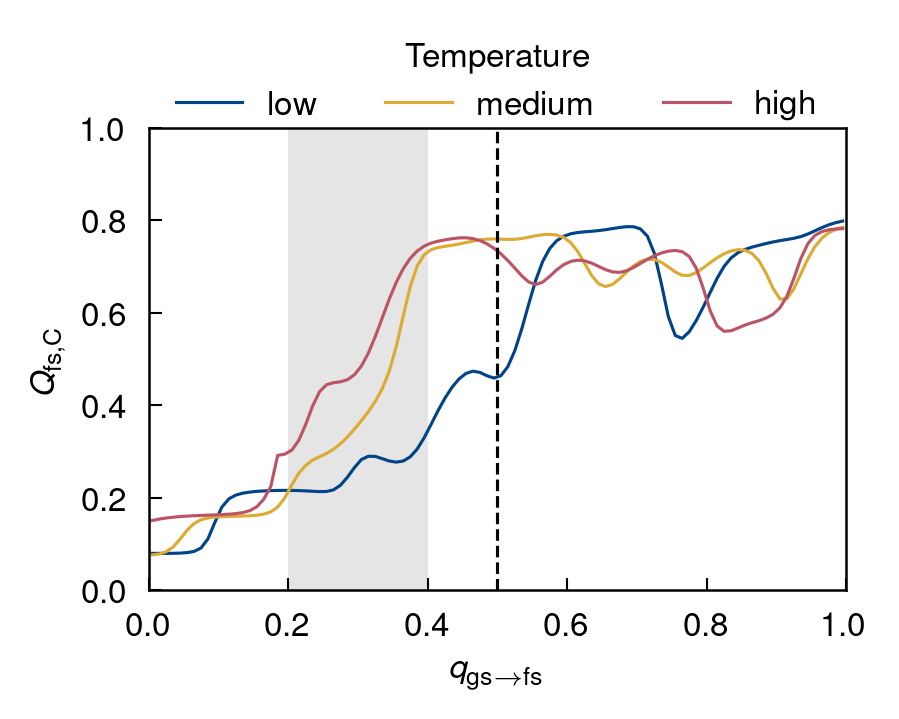

In [15]:
with mpl.style.context("high-contrast"):
    fig = plt.figure(figsize=(3, 2), dpi=300)
    cv1 = "q_fs"

    lag, mem = 100, 1
    xstd = 0.03

    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        q = np.asarray(qp)[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        numer, xe = kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
        denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        plt.plot(xc, numer / denom)
    plt.axvspan(0.2, 0.4, ec=None, color="gray", alpha=0.2)
    plt.axvline(0.5, color='black', ls='--')
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(labels[cv1])
    plt.xlim([0, 1])
    plt.ylim(lims[cv1])
    plt.legend(
        ["low", "medium", "high"], title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
    )
    fig.savefig("../../dga/figures/qp_qfs_ts.pdf", bbox_inches='tight')
    plt.show()

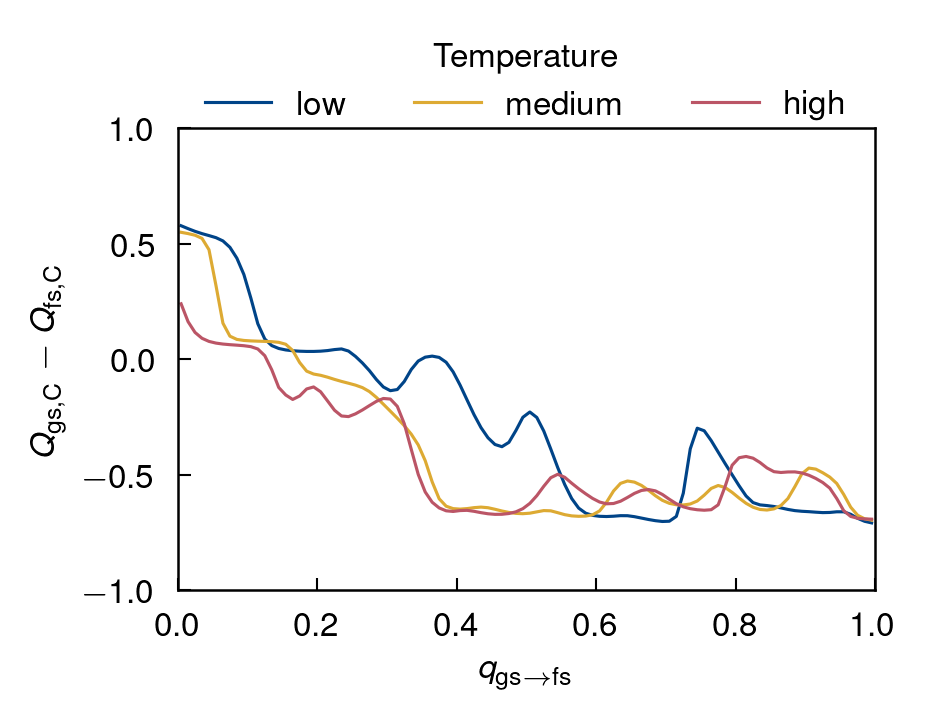

In [16]:
with mpl.style.context("high-contrast"):
    fig = plt.figure(figsize=(3, 2), dpi=300)

    lag, mem = 100, 1
    xstd = 0.02
    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        cv1_delay = cvs["q_gs"] - cvs["q_fs"]
        q = np.asarray(qp)[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        numer, xe = kdesum1d(q, cv1_delay[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
        denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        plt.plot(xc, numer / denom)
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(f"{labels['q_gs']} $-$ {labels['q_fs']}")
    plt.xlim([0, 1])
    plt.ylim([-1, 1])
    plt.legend(
        ["low", "medium", "high"], title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
    )
    plt.show()

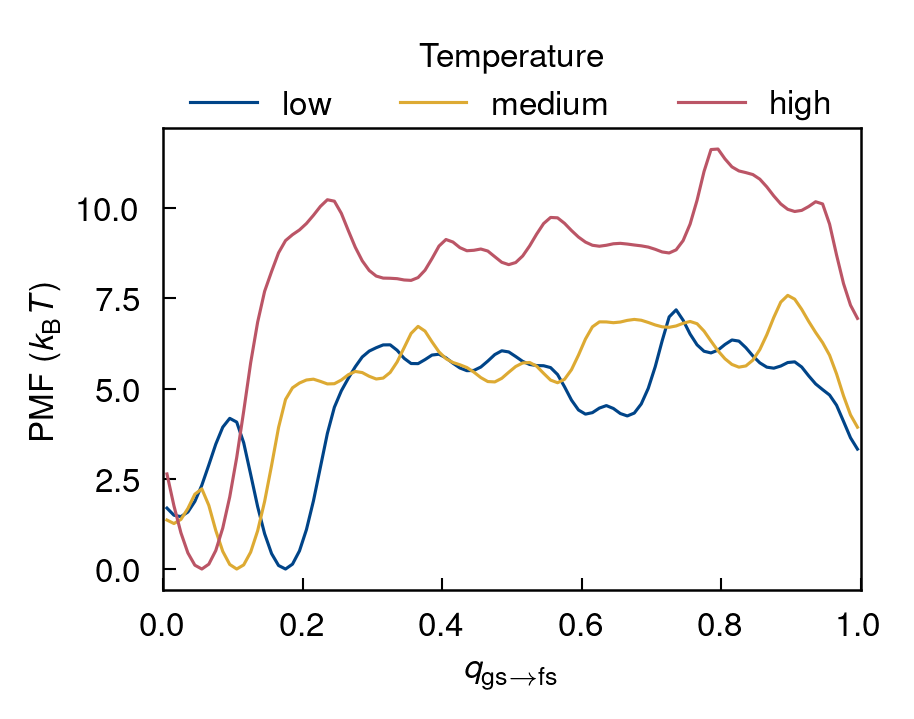

In [17]:
with mpl.style.context("high-contrast"):
    fig = plt.figure(figsize=(3, 2), dpi=300)

    lag, mem = 100, 1
    xstd = 0.02
    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        q = np.asarray(qp)[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        hist, xe = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        min_energy = np.min(-np.log(hist))
        pmf = -np.log(hist) - min_energy
        plt.plot(xc, pmf)
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(r"PMF ($k_{\mathrm{B}}T$)")
    plt.xlim([0, 1])
    # plt.ylim([-1, 1])
    plt.legend(
        ["low", "medium", "high"], title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
    )
    plt.show()
    # plt.savefig("../../dga/figures/pmf_qp_ts.pdf", bbox_inches='tight')

In [33]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(-0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(-0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig("../../dga/figures/pmfs_qdiff_qcore_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/17938022/ipykernel_881560/1509044429.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


/scratch/local/jobs/17938022/ipykernel_881560/110138068.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


<Figure size 450x450 with 0 Axes>

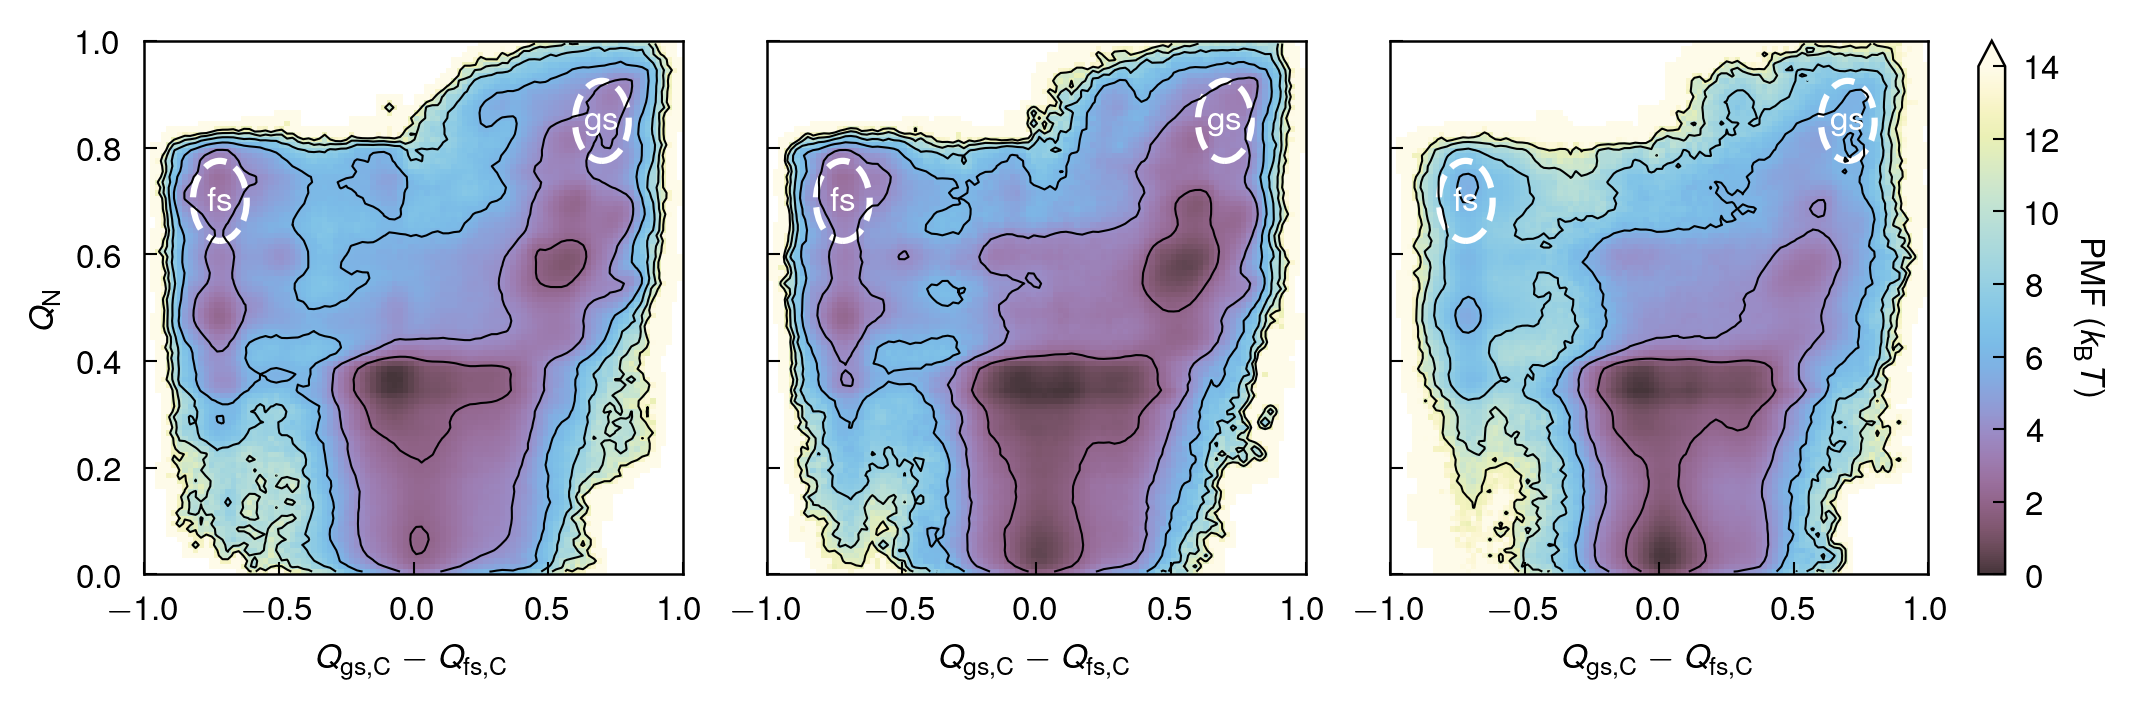

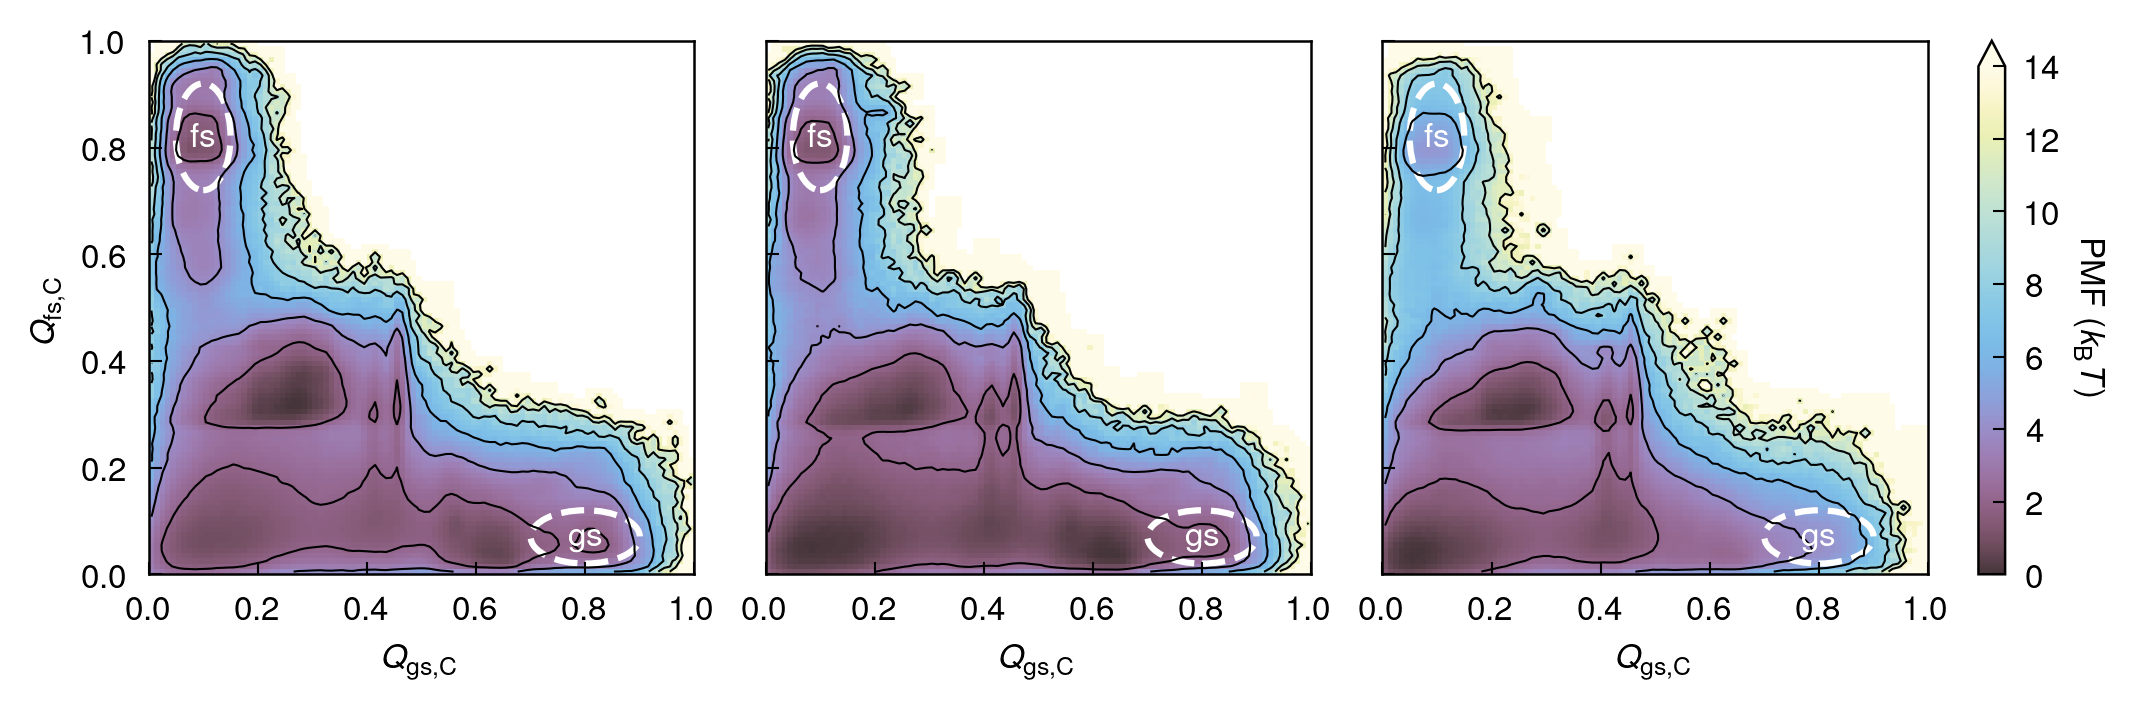

In [34]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs", "q_fs"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.8, 0.07), width=0.2, height=0.1)
    ellipseB = mpl.patches.Ellipse(xy=(0.1, 0.82), width=0.1, height=0.2)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.8, 0.07, "gs", ax=ax, color="white")
    pplt.text(0.1, 0.82, "fs", ax=ax, color="white")
plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)
plt.show()

/scratch/local/jobs/17938022/ipykernel_881560/977503500.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


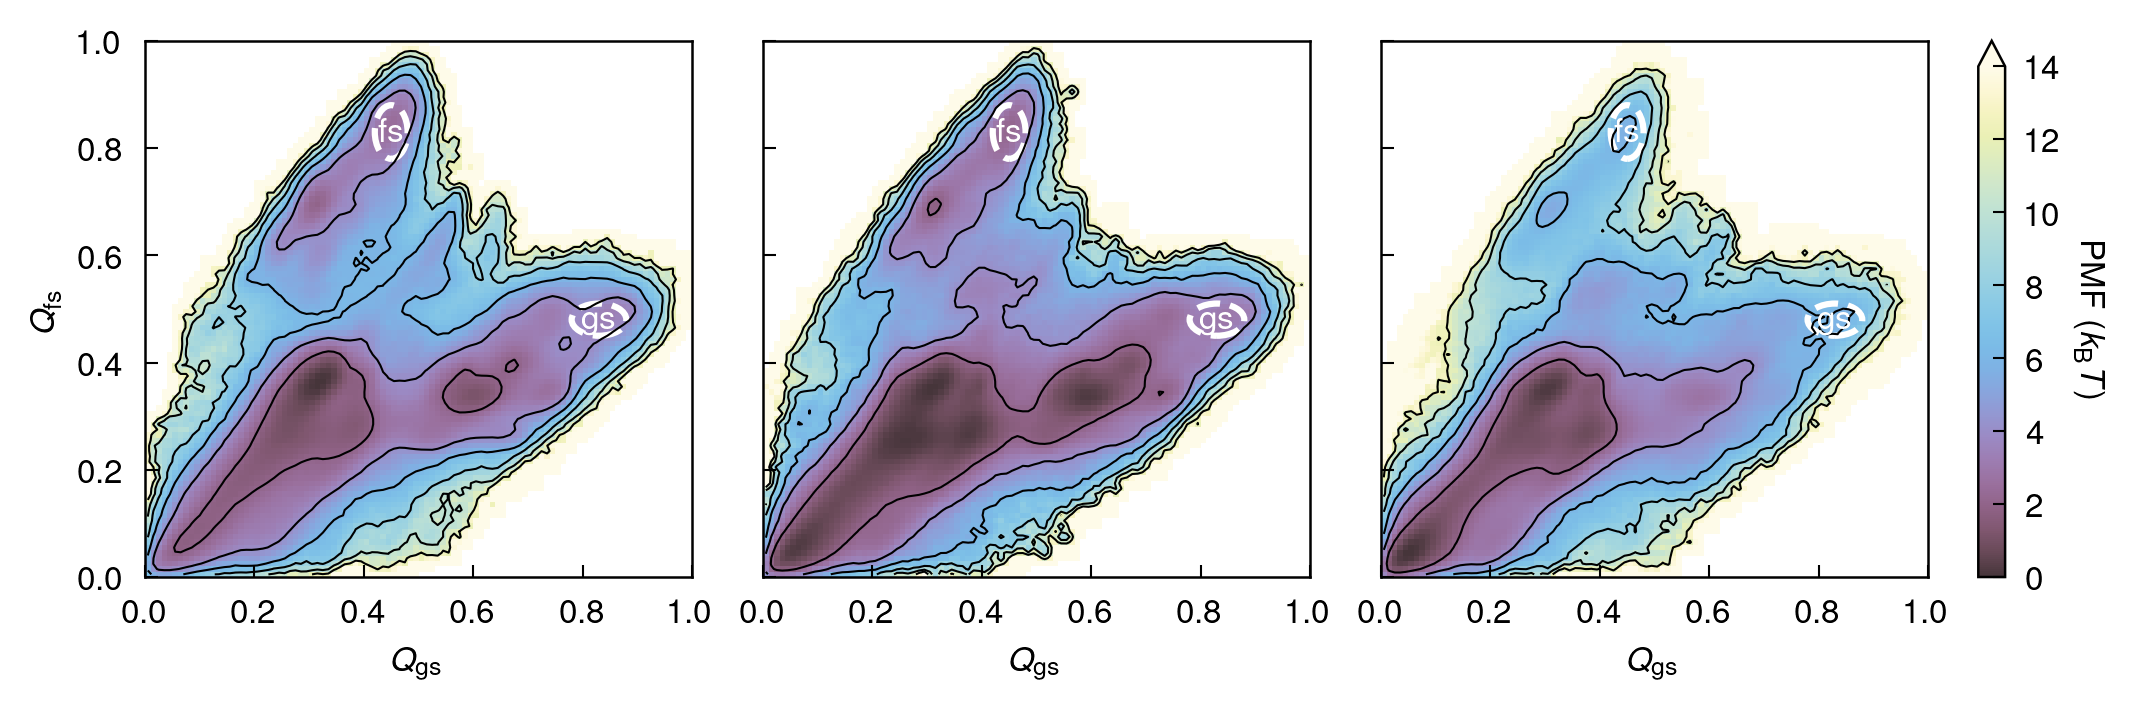

In [38]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs_all", "q_fs_all"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)
for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.83, 0.48), width=0.1, height=0.06)
    ellipseB = mpl.patches.Ellipse(xy=(0.45, 0.83), width=0.06, height=0.1)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.83, 0.48, "gs", ax=ax, color="white")
    pplt.text(0.45, 0.83, "fs", ax=ax, color="white")
plt.savefig("../../dga/figures/pmfs_qgsall_qfsall_ts.pdf", bbox_inches='tight', dpi=400)
plt.show()

/scratch/local/jobs/17938022/ipykernel_881560/1057416469.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


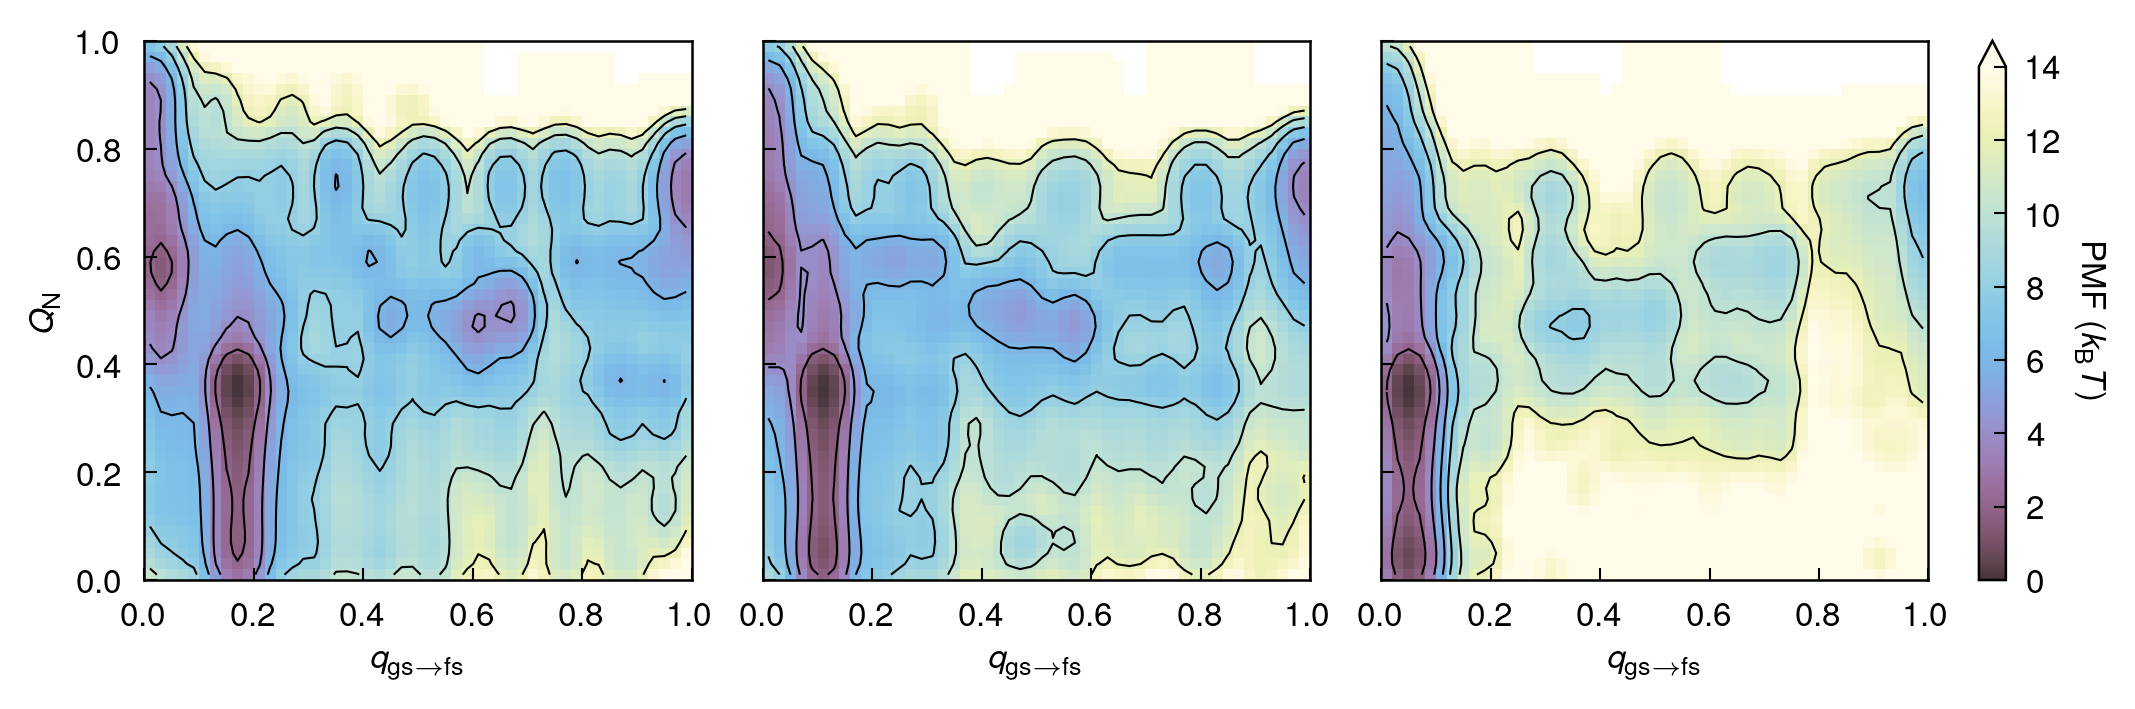

In [21]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv2 = "q_core"
xe = np.linspace(0, 1, 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=1, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels['qp'])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/17938022/ipykernel_881560/3006549172.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


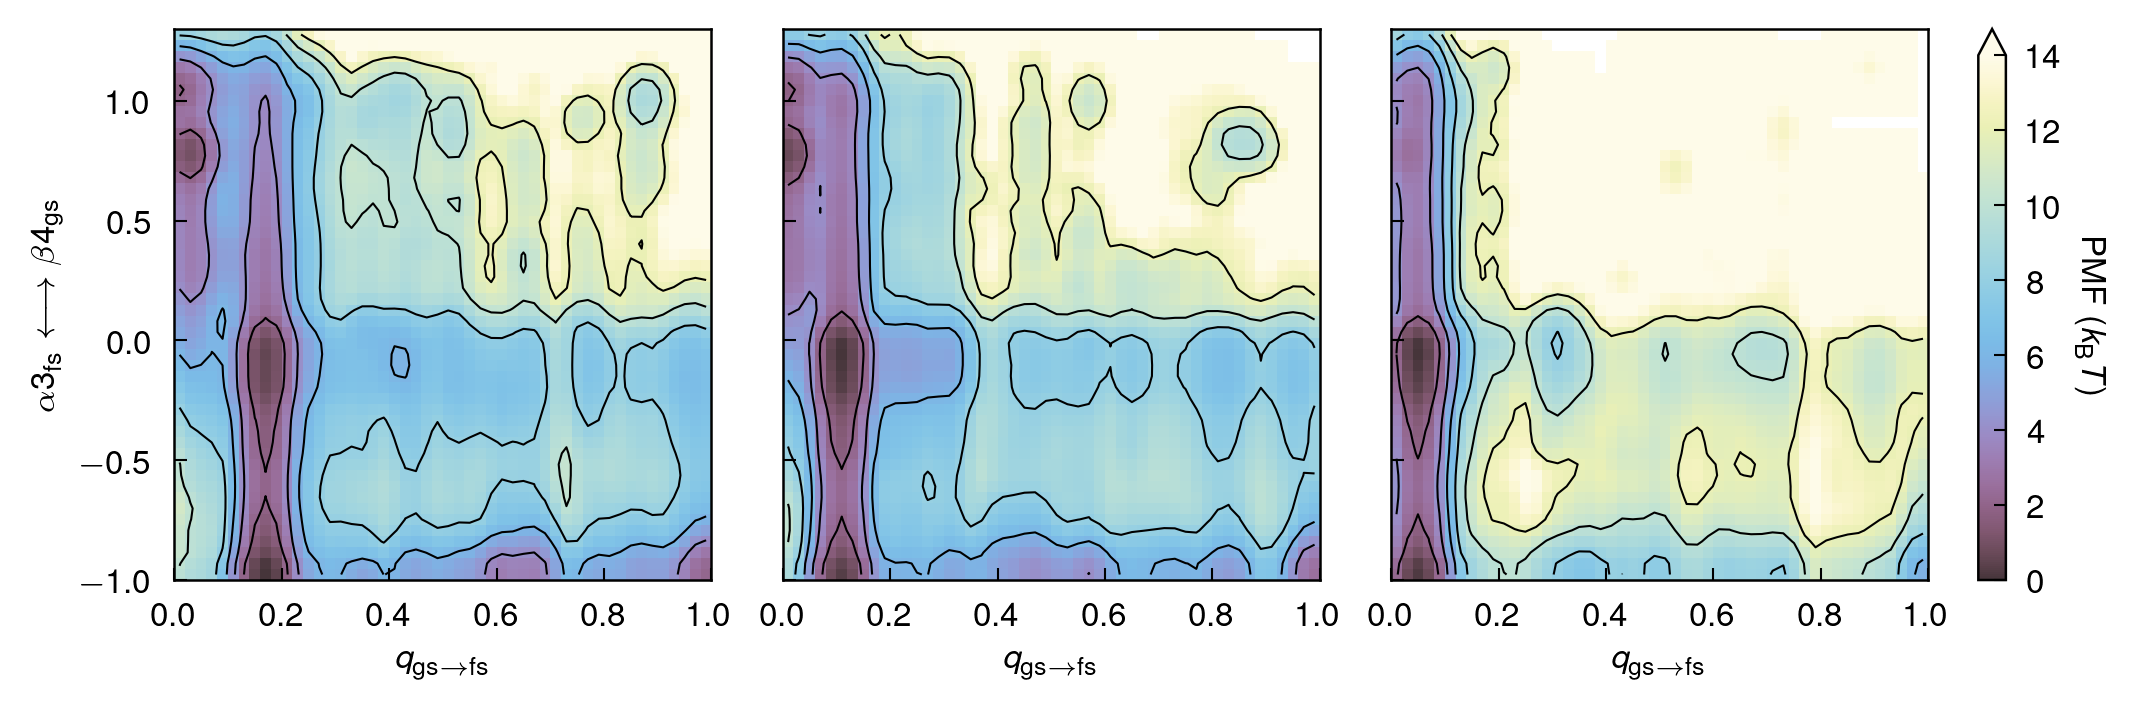

In [22]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv2 = "blue"
xe = np.linspace(0, 1, 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=1, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels['qp'])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

plt.show()

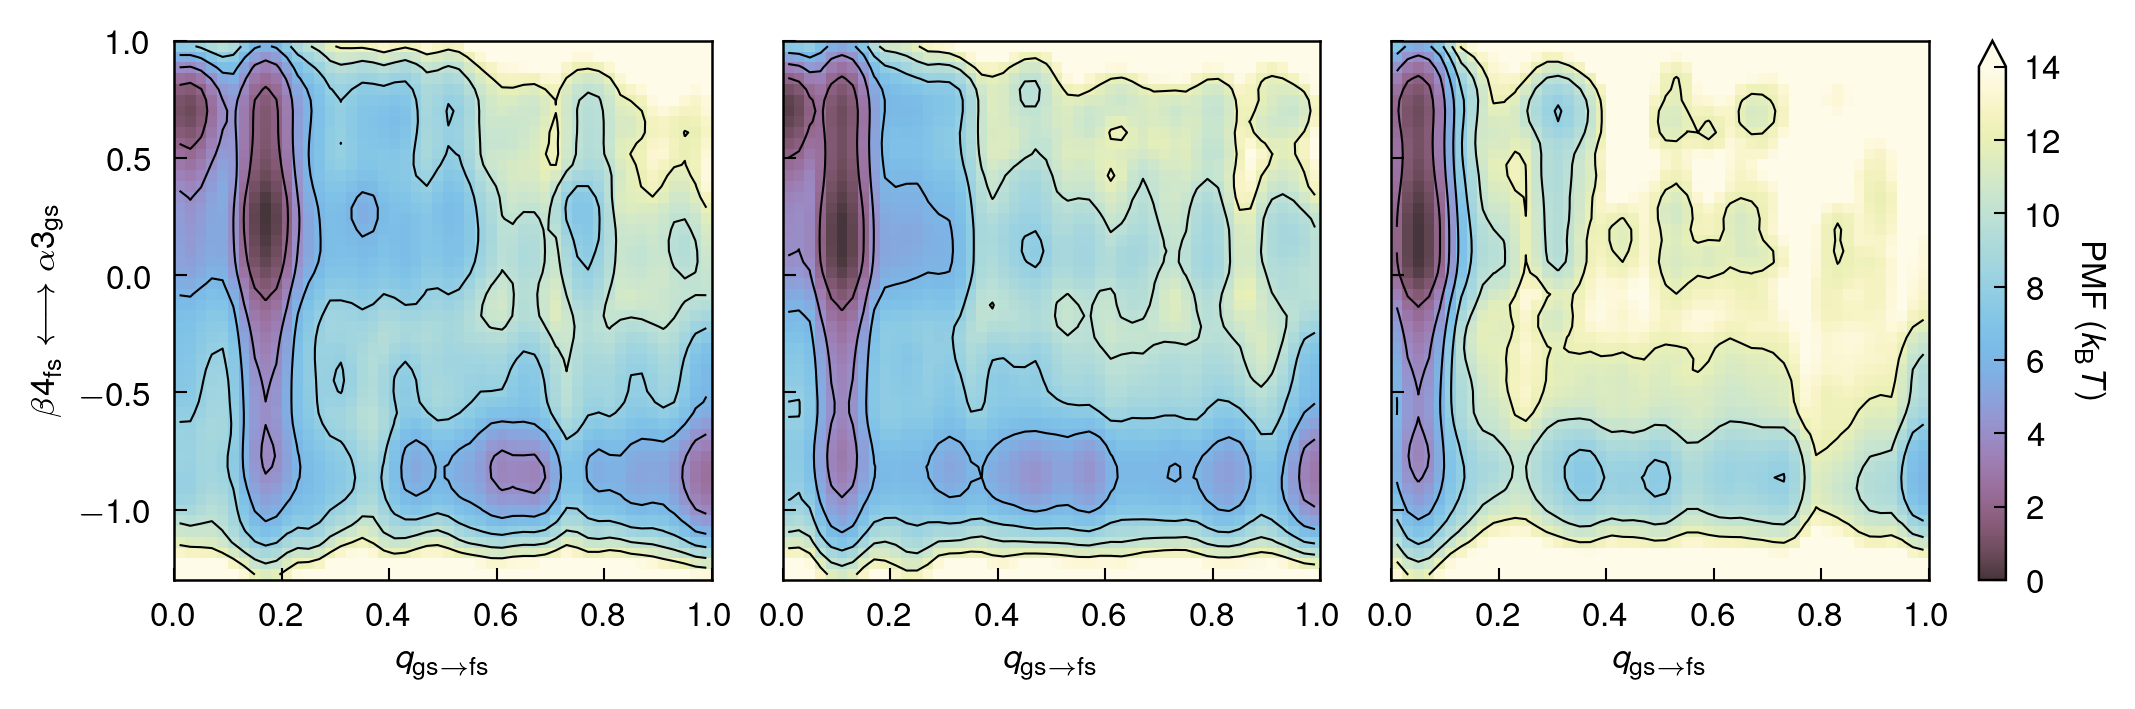

In [23]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv2 = "green"
xe = np.linspace(0, 1, 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=1, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels['qp'])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

plt.show()

/scratch/local/jobs/17938022/ipykernel_881560/2584449905.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


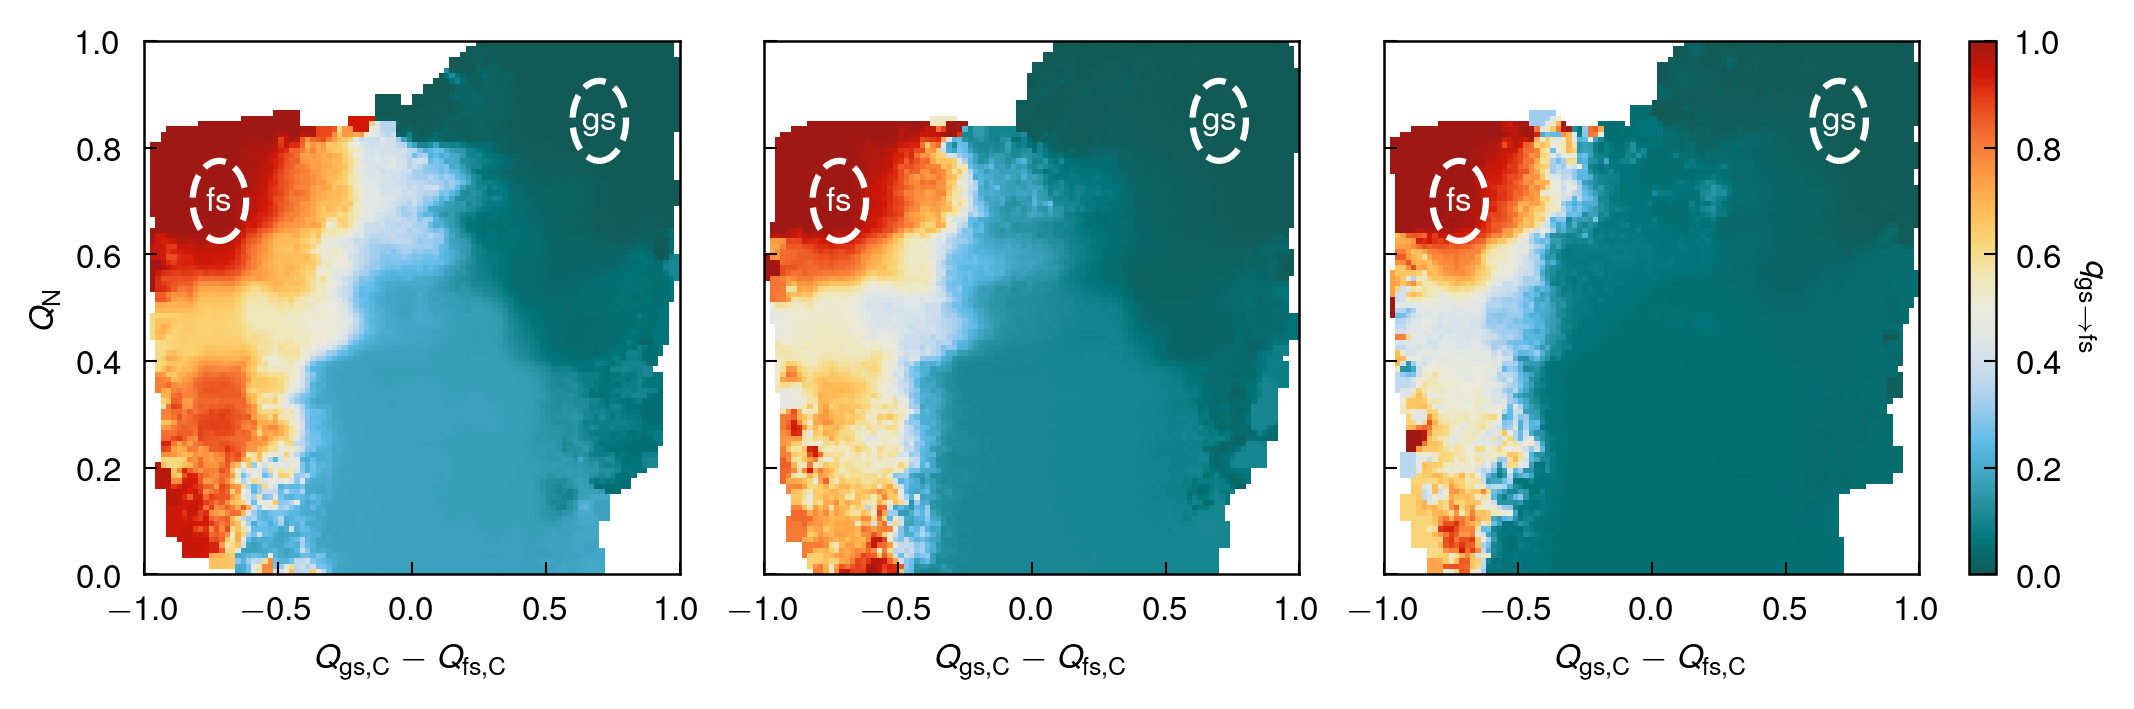

In [24]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=labels["qp"], rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(-0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(-0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig("../../dga/figures/qp_gs2fs_qdiff_qcore_ts.pdf", bbox_inches='tight', dpi=400)
plt.show()

/scratch/local/jobs/17938022/ipykernel_881560/3895890456.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


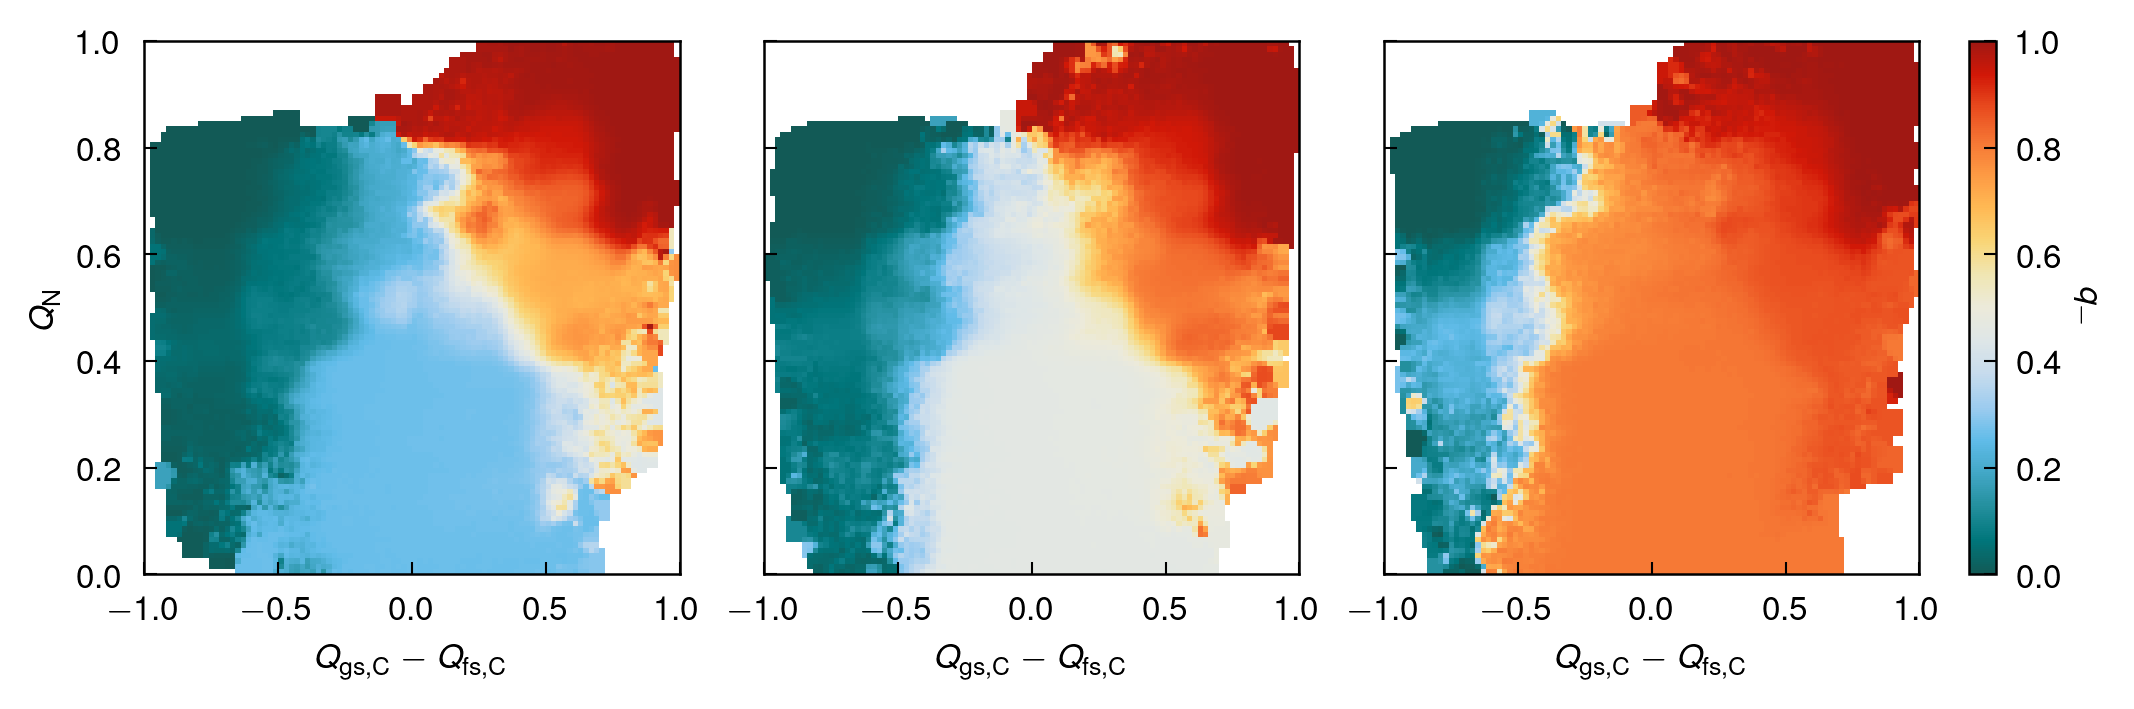

In [39]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qm in zip(axes, cvs_all_ts, weights_all_ts, qm_all_ts):
    cv1_delay = cvs[cv1][..., qlag:]
    cv2_delay = cvs[cv2][..., qlag:]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qm)[..., qlag:] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"$q_-$", rotation=-90, labelpad=10)
plt.show()

/scratch/local/jobs/17938022/ipykernel_881560/611431495.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


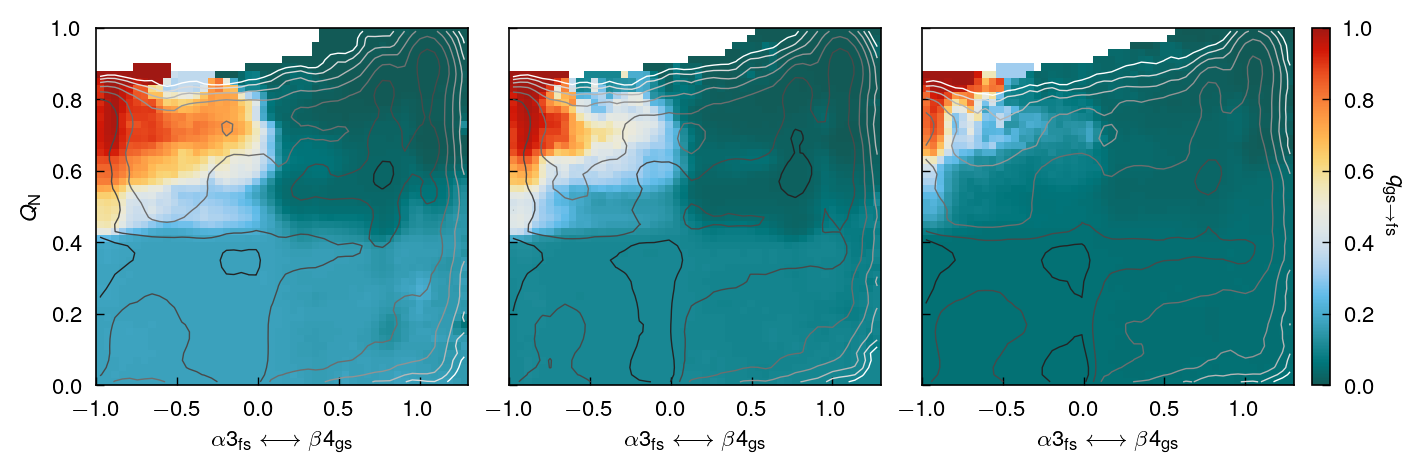

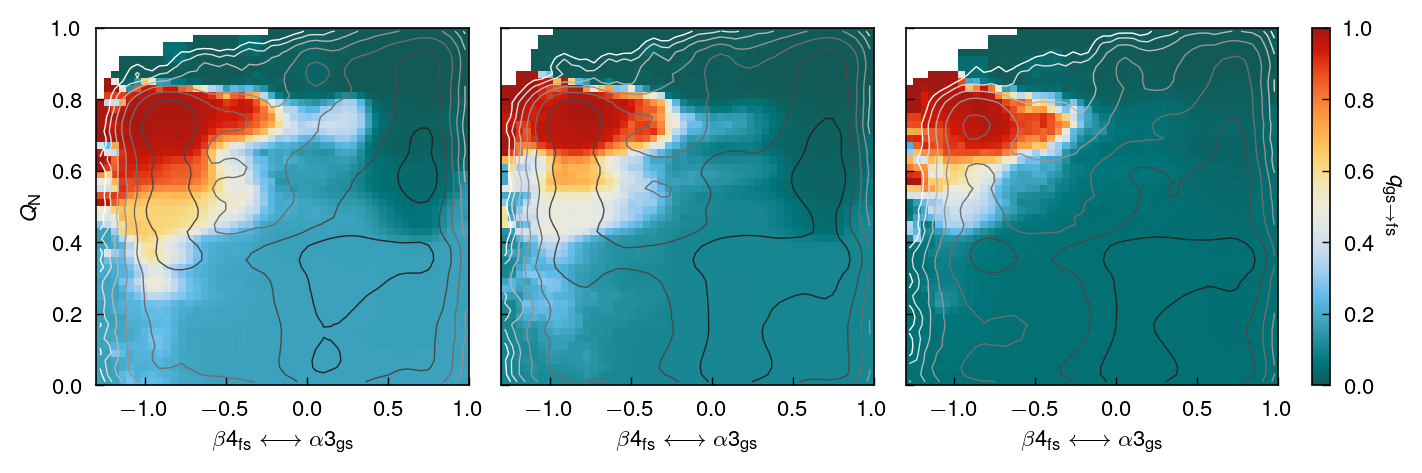

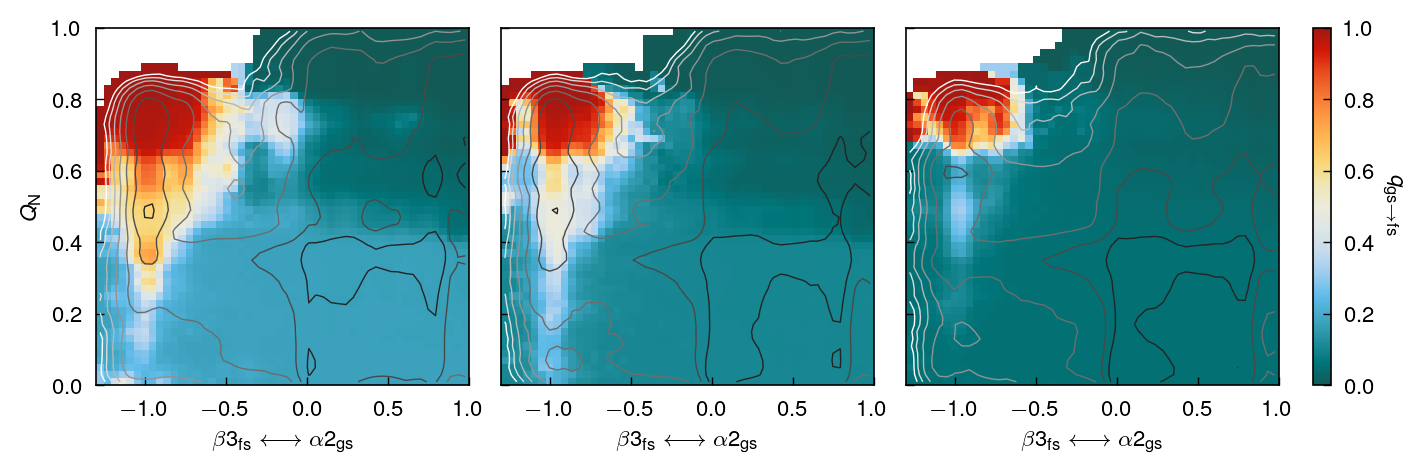

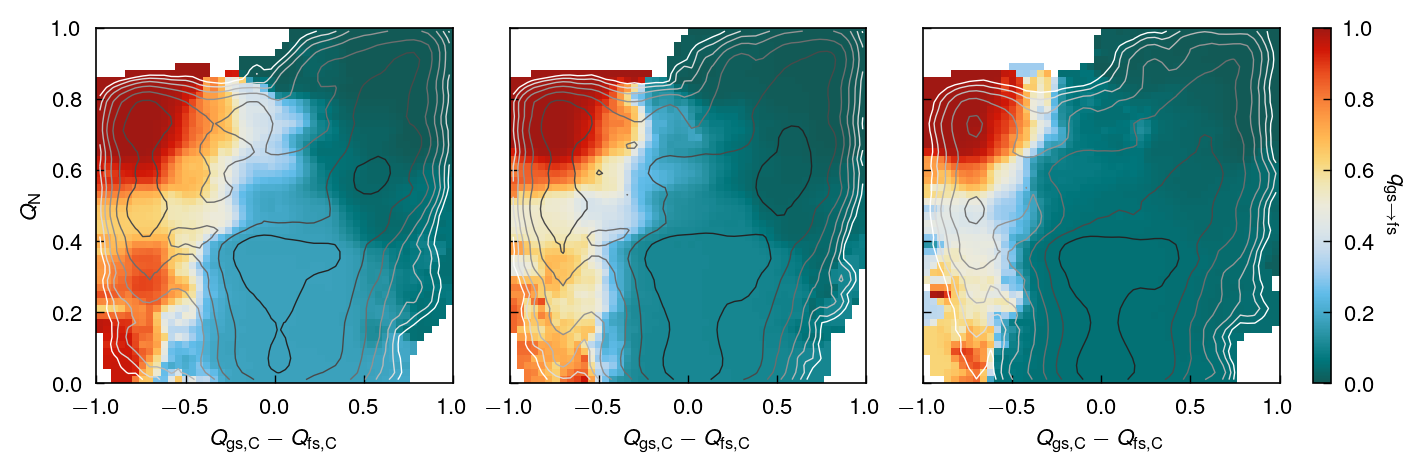

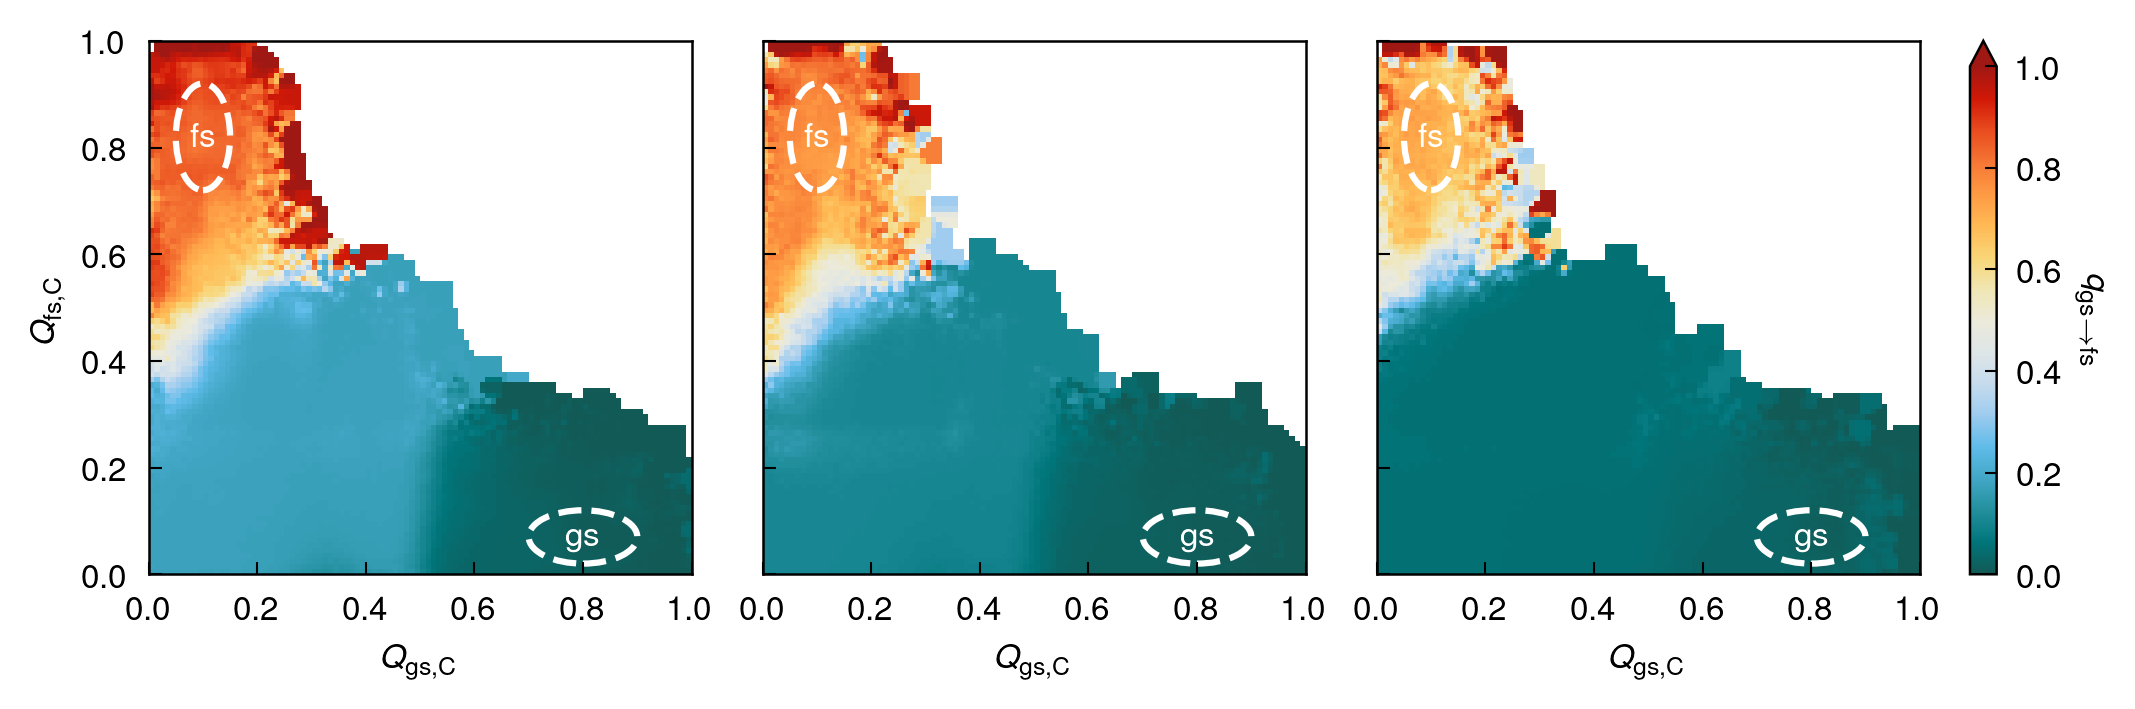

In [30]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs", "q_fs"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=labels["qp"], rotation=-90, labelpad=10)

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.8, 0.07), width=0.2, height=0.1)
    ellipseB = mpl.patches.Ellipse(xy=(0.1, 0.82), width=0.1, height=0.2)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.8, 0.07, "gs", ax=ax, color="white")
    pplt.text(0.1, 0.82, "fs", ax=ax, color="white")
plt.show()
# plt.savefig("../../dga/figures/pmfs_qdiff_qcore_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/17938022/ipykernel_881560/3548532734.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


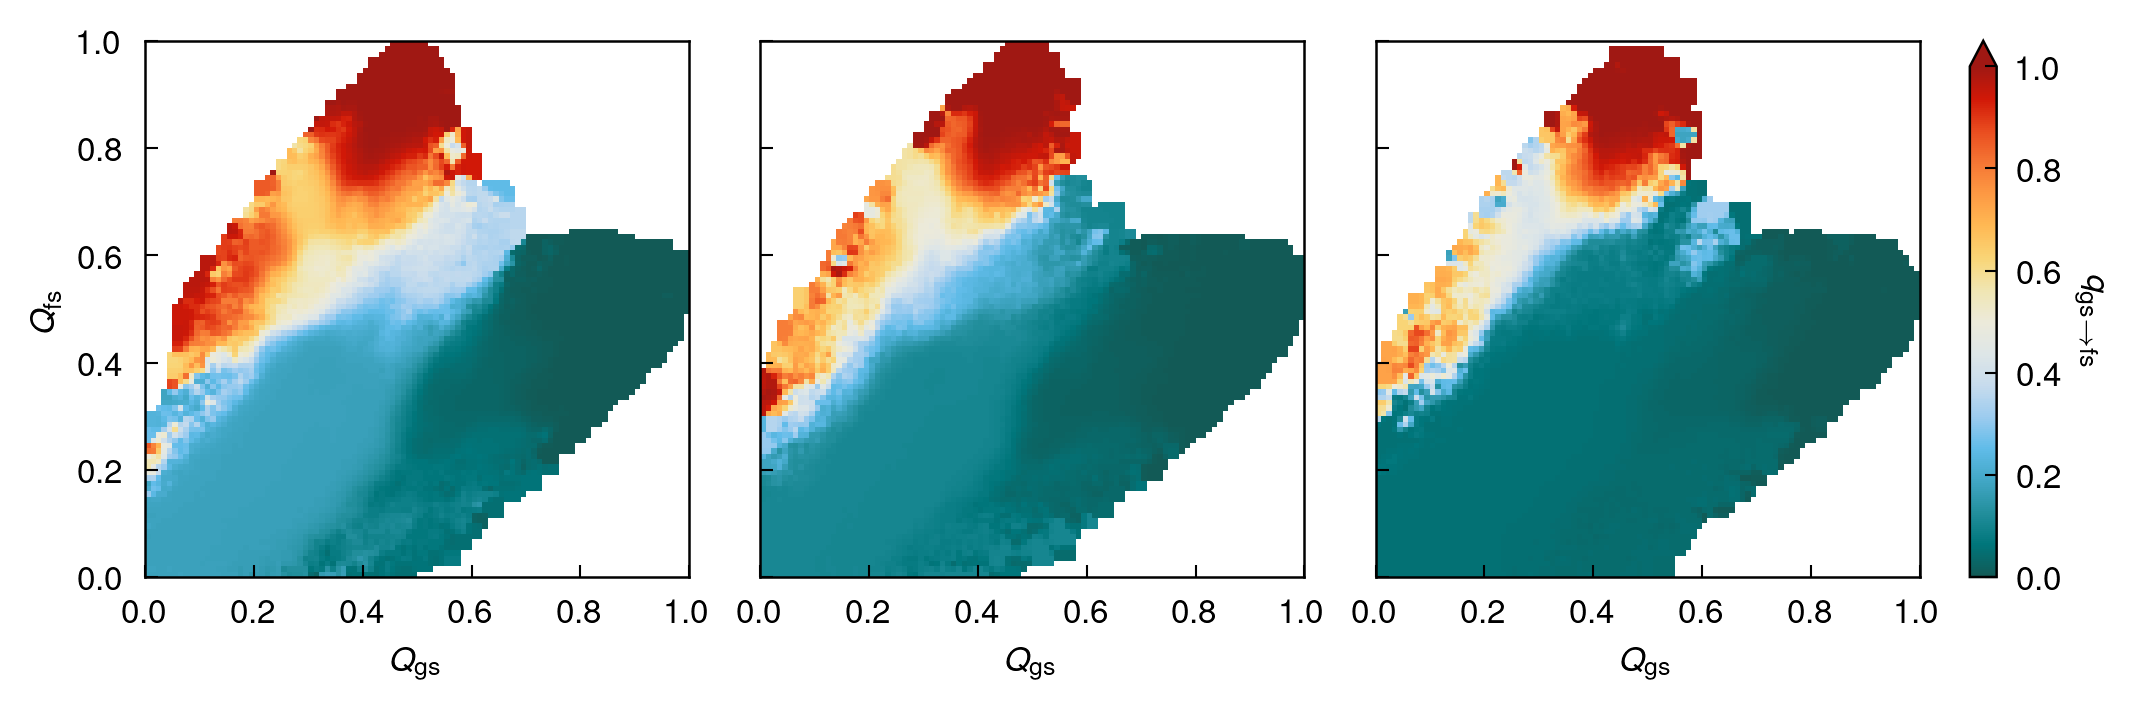

In [26]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs_all", "q_fs_all"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=labels["qp"], rotation=-90, labelpad=10)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qdiff_qcore_ts.pdf", bbox_inches='tight', dpi=400)

In [27]:
def plot_qp_pmf_ts(cv1, cv2):
    clines = np.arange(0, 15, 2)
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    xe = np.linspace(*lims[cv1], 51)
    ye = np.linspace(*lims[cv2], 51)
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    for ax, qp, cvs, sample_w in zip(axes, qp_all_ts, cvs_all_ts, weights_all_ts):
        cv1_delay = cvs[cv1][..., :-qlag]
        cv2_delay = cvs[cv2][..., :-qlag]
        w = extq.projection.density2d(
            cv1_delay,
            cv2_delay,
            np.broadcast_to(sample_w[..., None], cv1_delay.shape),
            xe,
            ye,
        )
        w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
        qw = extq.projection.density2d(
            cv1_delay,
            cv2_delay,
            np.asarray(qp)[..., :-qlag] * sample_w[..., None],
            xe,
            ye,
        )
        qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
        pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
        
        hist = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
        pmf = -np.log(hist) - np.min(-np.log(hist))
        ax.contour(xc, yc, pmf.T, cmap='gray', levels=clines, linewidths=0.5)
        ax.set_xlabel(labels[cv1])
        ax.set_ylabel(labels[cv2])
        ax.label_outer()
    cb = plt.colorbar(pc, ax=axes[-1])
    cb.set_label(label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)
    return fig

/scratch/local/jobs/17938022/ipykernel_881560/1338603313.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
/scratch/local/jobs/17938022/ipykernel_881560/1338603313.py:32: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


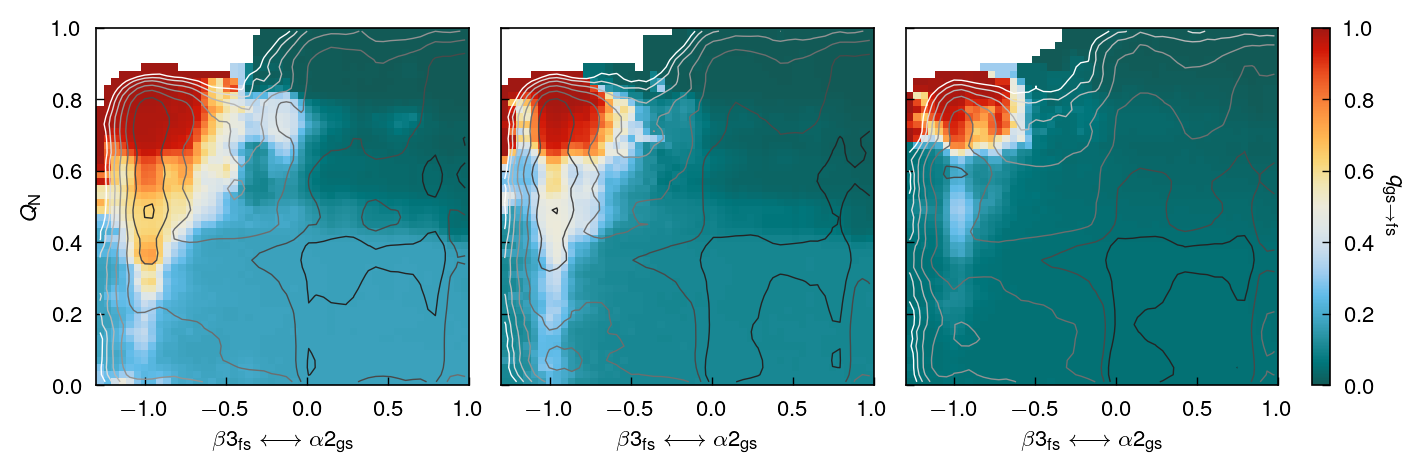

In [28]:
fig = plot_qp_pmf_ts("blue", "q_core")
fig
plot_qp_pmf_ts("green", "q_core")
plot_qp_pmf_ts("orange", "q_core")

/scratch/local/jobs/17938022/ipykernel_881560/1338603313.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
/scratch/local/jobs/17938022/ipykernel_881560/1338603313.py:32: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


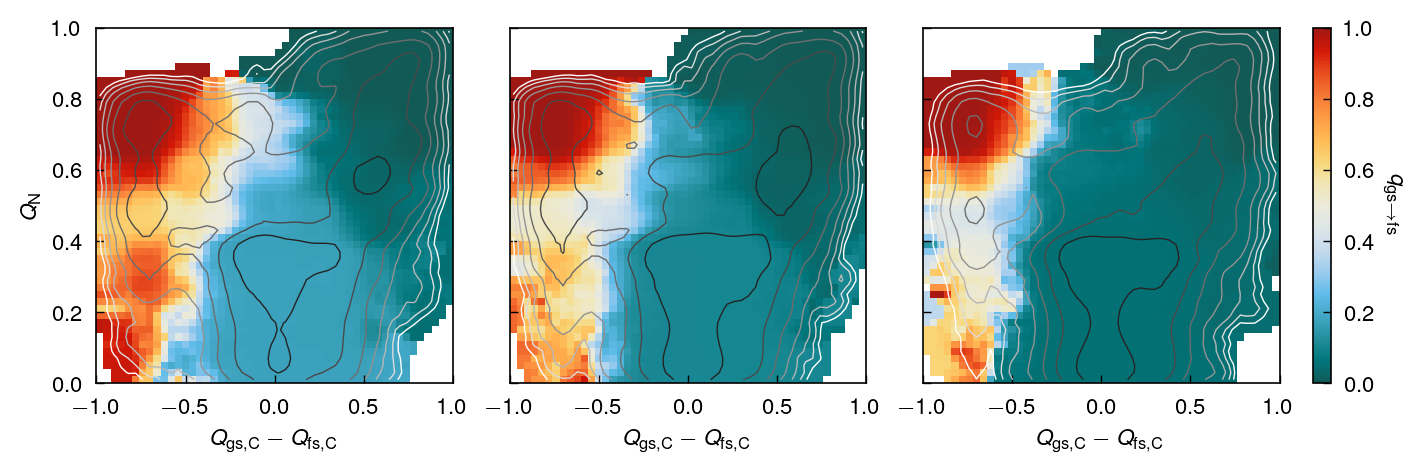

In [29]:
plot_qp_pmf_ts("q_diff", "q_core")

# load currents

In [82]:
def load_currents(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    js = dict()
    for cv in ["blue", "green", "orange", "q_core", "q_gs_all", "q_gs", "q_fs_all", "q_fs", "qp"]:
        j = np.load(f"{data_dir}/j_gs2fs_{cv}.npy")
        js[cv] = j
    return js

In [113]:
js_all_ts = []
for t in (87, 89, 91):
    js_all_ts.append(load_currents(t))

In [84]:
def kdesum2d(
    x,
    y,
    w,
    *,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    xstd=None,
    ystd=None,
    nx=100,
    ny=100,
    cut=4.0,
):
    """Compute a 2D kernel density estimate.

    This function histograms the data, then uses a Gaussian filter to
    approximate a kernel density estimate with a Gaussian kernel.

    Credit to Chatipat Lorpaiboon for this code.

    Parameters
    ----------
    x, y : ndarray or list/tuple of ndarray
        Coordinates of each frame.
    w : ndarray or list/tuple of ndarray
        Weight or value of each frame. The output is the sum of these
        values in each bin, after smoothing.
    xmin, xmax, ymin, ymax : float, optional
        Limits of kernel density estimate. If None, takes the min/max
        of the data along the coordinate.
    xstd, ystd : float, optional
        Standard deviation of the Gaussian filter. If None, these are
        set to (xmax - xmin) / nx and (ymax - ymin) / ny, respectively.
        Increase this to smooth the results more.
    nx, ny : int, optional
        Number of bins in each dimension. This should be set as high as
        reasonable, since xstd/ystd takes care of the smoothing.
    cut : float, optional
        Number of standard deviations at which to truncate the Gaussian
        filter. The default, 4, usually doesn't need to be changed.

    Returns
    -------
    kde : (nx, ny) ndarray
        Kernel density estimate, given as bins.
    xedges : (nx+1,) ndarray
        Bin edges along the x dimension.
    yedges : (ny+1,) ndarray
        Bin edges along the y dimension.

    """

    # flatten input to 1D arrays
    x = _flatten(x)
    y = _flatten(y)
    w = _flatten(w)

    # limits
    _xmin = np.min(x)
    _xmax = np.max(x)
    _ymin = np.min(y)
    _ymax = np.max(y)
    if xmin is None:
        xmin = _xmin
    if xmax is None:
        xmax = _xmax
    if ymin is None:
        ymin = _ymin
    if ymax is None:
        ymax = _ymax

    # separation between grid points
    xsep = (xmax - xmin) / nx
    ysep = (ymax - ymin) / ny

    # number of grid points to pad the boundaries,
    # since the Gaussian filter extends beyond the boundaries
    # usually overestimates the padding, but whatever
    ax = max(0, int(np.ceil((xmin - _xmin) / xsep + 1e-6)))
    bx = max(0, int(np.ceil((_xmax - xmax) / xsep + 1e-6)))
    ay = max(0, int(np.ceil((ymin - _ymin) / ysep + 1e-6)))
    by = max(0, int(np.ceil((_ymax - ymax) / ysep + 1e-6)))

    # output bin edges
    xedges = np.linspace(xmin, xmax, nx + 1)
    yedges = np.linspace(ymin, ymax, ny + 1)

    # bin edges, with the added padding
    xedges_padded = np.concatenate(
        [
            xmin + xsep * np.arange(-ax, 0),
            xedges,
            xmax + xsep * np.arange(1, bx + 1),
        ]
    )
    yedges_padded = np.concatenate(
        [
            ymin + ysep * np.arange(-ay, 0),
            yedges,
            ymax + ysep * np.arange(1, by + 1),
        ]
    )
    assert np.allclose(xedges_padded[1:] - xedges_padded[:-1], xsep)
    assert np.allclose(yedges_padded[1:] - yedges_padded[:-1], ysep)
    assert xedges_padded[0] <= _xmin and _xmax <= xedges_padded[-1]
    assert yedges_padded[0] <= _ymin and _ymax <= yedges_padded[-1]

    # construct 2D histogram on padded edges
    hist_padded, _, _ = np.histogram2d(x, y, weights=w, bins=(xedges_padded, yedges_padded))

    # Gaussian kernel parameters
    if xstd is None:
        xstd = xsep
    if ystd is None:
        ystd = ysep

    # apply Gaussian filter to histogram
    kde_padded = scipy.ndimage.gaussian_filter(
        hist_padded,
        sigma=(xstd / xsep, ystd / ysep),  # in units of grid points
        mode="constant",
        truncate=cut,
    )

    # remove the padding
    assert ax + nx + bx == kde_padded.shape[0]
    assert ay + ny + by == kde_padded.shape[1]
    kde = kde_padded[ax : ax + nx, ay : ay + ny]

    return kde, xedges, yedges


def _flatten(a):
    if isinstance(a, np.ndarray):
        # avoid creating a new array (and using twice the memory)
        return np.ravel(a)
    else:
        return np.ravel(np.concatenate(a))

In [86]:
def plot_current(
    cv1,
    cv2,
    jx,
    jy,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j="viridis",
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = kdesum2d(
        cv1,
        cv2,
        jx,
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = kdesum2d(
        cv1,
        cv2,
        jy,
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned**2 + jy_binned**2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )
    return ax, quiv

In [94]:
fig, axes = plt.subplots(2, 2, dpi=200, figsize=(6, 6), sharex=True, sharey=True, constrained_layout=True)
cv1, cv2 = "green", "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs_all_ts[0][cv1]
cv2_delay = cvs_all_ts[0][cv2]
weights = np.broadcast_to(weights_all_ts[0][..., None], cv1_delay.shape)
hist = extq.projection.density2d(
    cv1_delay,
    cv2_delay,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pmf = -np.log(hist) - np.min(-np.log(hist))
clines = np.arange(0, 13)

for i, ax in enumerate(axes.flat):
    jcv1 = js_all_ts[0][cv1][i]
    jcv2 = js_all_ts[0][cv2][i]
    ax.contour(xc, yc, pmf.T, colors="Greys", levels=clines, linewidths=1)
    _, quiv = plot_current(cv1_delay, cv2_delay, jcv1, jcv2, weights, *lims[cv1], *lims[cv2], 20, ax=ax)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(quiv, ax=axes[-1])
cb.set_label(label=r"J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)
plt.show()

/scratch/local/jobs/17249099/ipykernel_3955287/125304167.py:18: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


# Load fluxes

In [22]:
def load_rates():
    rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs = [], [], [], []
    for temp in (87, 89, 91):
        base_dir = f"{home_dir}/dga/new_{temp}"
        data_dir = f"{base_dir}/data"
        rates_ts_gs2fs.append(np.load(f"{data_dir}/rates_gs2fs.npy"))
        rates_withc_ts_gs2fs.append(np.load(f"{data_dir}/rates_gs2fs_withc.npy"))
        rates_ts_fs2gs.append(np.load(f"{data_dir}/rates_fs2gs.npy"))
        rates_withc_ts_fs2gs.append(np.load(f"{data_dir}/rates_fs2gs_withc.npy"))
    return rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs

In [23]:
rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs = load_rates()

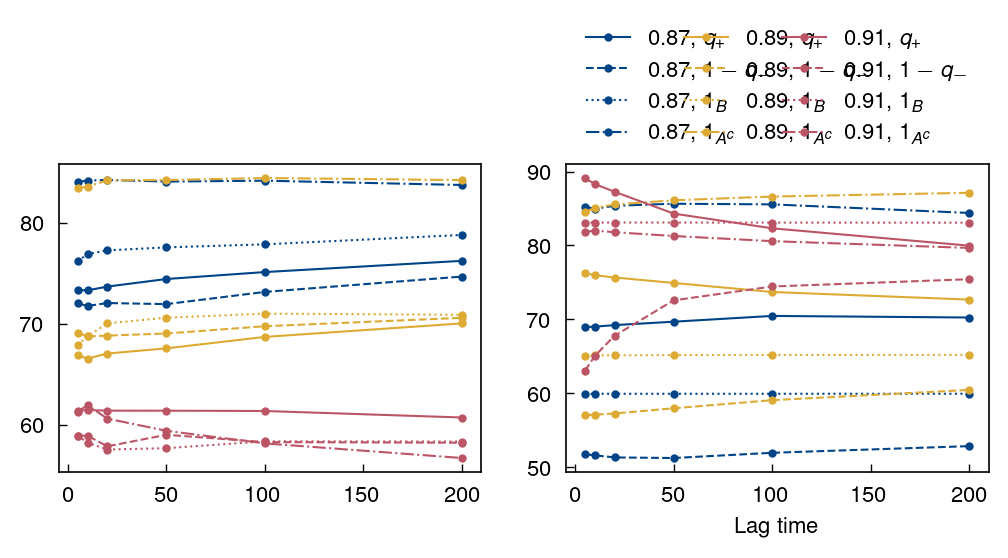

In [24]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(6, 2))
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)
with plt.style.context("high-contrast"):
    linestyles = ["-", "--", ":", "-."]
    colors = ["C0", "C1", "C2"]
    Ts = [0.87, 0.89, 0.91]
    rcs = [r"$q_+$", r"$1 - q_-$", r"$1_{B}$", r"$1_{A^c}$"]
    for r_gs2fs, r_gs2fs_withc, c, T in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs, colors, Ts):
        for r, r_withc, ls, rc in zip(r_gs2fs, r_gs2fs_withc, linestyles, rcs):
            percent_through = r_withc / (r_withc + r)
            axes[0].plot(lags, percent_through * 100, ls=ls, color=c, marker="o", label=f"{T}, {rc}")
    for r_fs2gs, r_fs2gs_withc, c, T in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs, colors, Ts):
        for r, r_withc, ls, rc in zip(r_fs2gs, r_fs2gs_withc, linestyles, rcs):
            percent_through = r_withc / (r_withc + r)
            axes[1].plot(lags, percent_through * 100, ls=ls, color=c, marker="o")
    plt.xlabel("Lag time")
    plt.ylabel("% through unfolded state")
    pplt.legend(outside="top", axs=axes, ax=axes, ncols=3)
    plt.show()

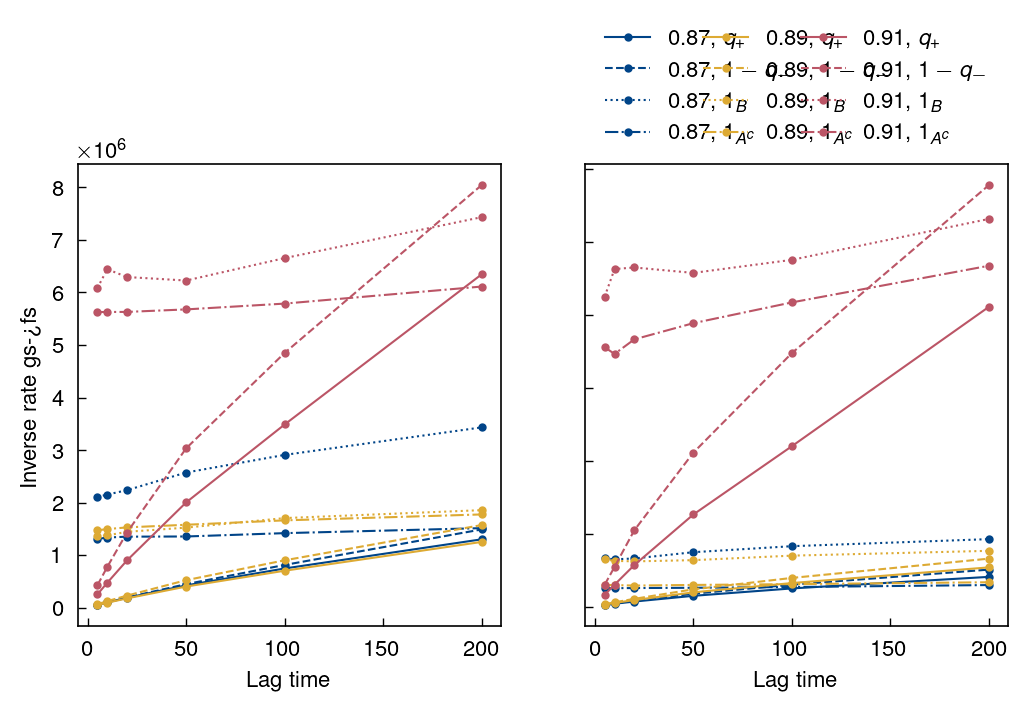

In [27]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(6, 3), sharex=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)
with plt.style.context("high-contrast"):
    linestyles = ["-", "--", ":", "-."]
    colors = ["C0", "C1", "C2"]
    Ts = [0.87, 0.89, 0.91]
    rcs = [r"$q_+$", r"$1 - q_-$", r"$1_{B}$", r"$1_{A^c}$"]
    for r_gs2fs, r_gs2fs_withc, c, T in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs, colors, Ts):
        for r, r_withc, ls, rc in zip(r_gs2fs, r_gs2fs_withc, linestyles, rcs):
            percent_through = r_withc / (r_withc + r)
            axes[0].plot(lags, 1 / r, ls=ls, color=c, marker="o", label=f"{T}, {rc}")
            axes[1].plot(lags, 1 / r_withc, ls=ls, color=c, marker="o")
    for ax in axes:
        ax.set_xlabel("Lag time")
        ax.set_ylabel("Inverse rate gs->fs")
        ax.label_outer()
    pplt.legend(outside="top", axs=axes, ncols=3)
    plt.show()

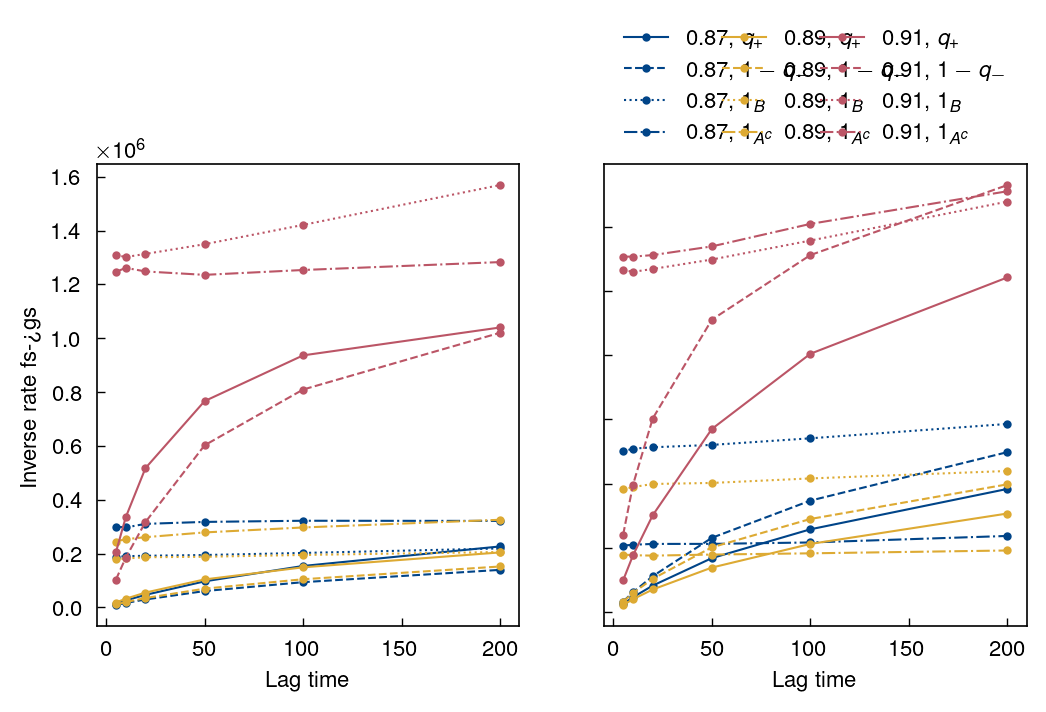

In [28]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(6, 3), sharex=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)
with plt.style.context("high-contrast"):
    linestyles = ["-", "--", ":", "-."]
    colors = ["C0", "C1", "C2"]
    Ts = [0.87, 0.89, 0.91]
    rcs = [r"$q_+$", r"$1 - q_-$", r"$1_{B}$", r"$1_{A^c}$"]
    for r_fs2gs, r_fs2gs_withc, c, T in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs, colors, Ts):
        for r, r_withc, ls, rc in zip(r_fs2gs, r_fs2gs_withc, linestyles, rcs):
            percent_through = r_withc / (r_withc + r)
            axes[0].plot(lags, 1 / r, ls=ls, color=c, marker="o", label=f"{T}, {rc}")
            axes[1].plot(lags, 1 / r_withc, ls=ls, color=c, marker="o")
    for ax in axes:
        ax.set_xlabel("Lag time")
        ax.set_ylabel("Inverse rate fs->gs")
        ax.label_outer()
    pplt.legend(outside="top", axs=axes, ncols=3)
    plt.show()

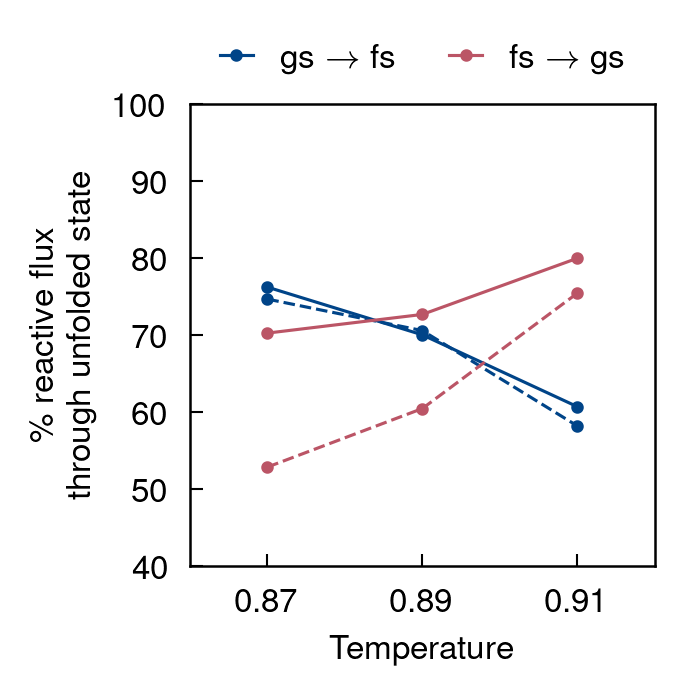

In [29]:
with plt.style.context("high-contrast"):
    fig = plt.figure(dpi=300, figsize=(2, 2))
    Ts = [0.87, 0.89, 0.91]
    ratios_gs2fs, ratios_fs2gs = [], []
    for r_gs2fs, r_gs2fs_withc in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs):
        r = r_gs2fs[:, -1]  # qp as rc
        r_withc = r_gs2fs_withc[:, -1]
        percent_through = r_withc / (r_withc + r)
        ratios_gs2fs.append(percent_through)
    for r_fs2gs, r_fs2gs_withc in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs):
        r = r_fs2gs[:, -1]  # qp as rc
        r_withc = r_fs2gs_withc[:, -1]
        percent_through = r_withc / (r_withc + r)
        ratios_fs2gs.append(percent_through)

    plt.plot(
        Ts,
        np.array(ratios_gs2fs)[:, 0] * 100,
        "-o",
        color="C0",
        label=r"$\mathrm{gs}\rightarrow\mathrm{fs}$",
    )
    plt.plot(Ts, np.array(ratios_gs2fs)[:, 1] * 100, "--o", color="C0")
    plt.plot(
        Ts,
        np.array(ratios_fs2gs)[:, 0] * 100,
        "-o",
        color="C2",
        label=r"$\mathrm{fs}\rightarrow\mathrm{gs}$",
    )
    plt.plot(Ts, np.array(ratios_fs2gs)[:, 1] * 100, "--o", color="C2")
    plt.xlabel("Temperature")
    plt.ylabel("\% reactive flux\nthrough unfolded state")
    plt.xticks(ticks=Ts)
    plt.xlim([0.86, 0.92])
    plt.ylim([40, 100])
    pplt.legend(outside="top", handlelength=1)
    plt.show()
    fig.savefig("../../../dga/figures/flux_ratio_ts.pdf", bbox_inches="tight")

# DSSP

In [ ]:
def compute_per_res_prob_ss(dssp):
    total = len(dssp)
    prob_helix = np.count_nonzero(dssp == 0, axis=0) / total
    prob_strand = np.count_nonzero(dssp == 1, axis=0) / total
    prob_coil = np.count_nonzero(dssp == 2, axis=0) / total
    assert np.allclose(prob_helix + prob_strand + prob_coil, 1)
    return prob_helix, prob_strand, prob_coil

In [144]:
import matplotlib.patches as mpatches

In [149]:
def draw_ss(ax, y1, y2, c0, c1, width = 1.0, height = 0.001, textoffset=0.5):
    fs_artists = [
        mpatches.Arrow(8, y1, 6, 0, width=width, color=c0),
        mpatches.FancyBboxPatch((20, y1 - height / 2), 15, height, ec="none", color=c1),
        mpatches.Arrow(40, y1, 6, 0, width=width, color=c0),
        mpatches.FancyBboxPatch((49, y1 - height / 2), 7, height, ec="none", color=c1),
        mpatches.Arrow(63, y1, 6, 0, width=width, color=c0),
        mpatches.Arrow(72, y1, 5, 0, width=width, color=c0),
        mpatches.FancyBboxPatch((83, y1 - height), 11, height, ec="none", color=c1),
    ]
    for artist in fs_artists:
        ax.add_artist(artist)

    gs_artists = [
        mpatches.Arrow(8, y2, 6, 0, width=width, color=c0),
        mpatches.FancyBboxPatch((20, y2 - height / 2), 15, height, ec="none", color=c1),
        mpatches.Arrow(40, y2, 6, 0, width=width, color=c0),
        mpatches.Arrow(58, y2, 3, 0, width=width, color=c0),
        mpatches.FancyBboxPatch((61, y2 - height / 2), 6, height, ec="none", color=c1),
        mpatches.FancyBboxPatch((71, y2 - height / 2), 10, height, ec="none", color=c1),
        mpatches.Arrow(87, y2, 7, 0, width=width, color=c0),
    ]
    for artist in gs_artists:
        ax.add_artist(artist)

    # fs labels
    ss_locs = [11, 27, 43, 52, 66, 74, 88]
    ss_labels = [
        r"$\beta1$",
        r"$\alpha1$",
        r"$\beta2$",
        r"$\alpha2$",
        r"$\beta3$",
        r"$\beta4$",
        r"$\alpha3$",
    ]
    for x, label in zip(ss_locs, ss_labels):
        ax.text(x, y1 + textoffset, label, ha="center")

    # gs labels
    ss_locs = [11, 27, 43, 59, 64, 76, 90]
    ss_labels = [
        r"$\beta1$",
        r"$\alpha1$",
        r"$\beta2$",
        r"$\beta3$",
        r"$\alpha2$",
        r"$\alpha3$",
        r"$\beta4$",
    ]
    for x, label in zip(ss_locs, ss_labels):
        ax.text(x, y2 + textoffset, label, ha="center")
    return ax

In [117]:
dssps_all_ts = []
for t in (87, 89, 91):
    base_dir = f"{home_dir}/dga/new_{t}"
    data_dir = f"{base_dir}/data"
    dssps_all_ts.append(load_cv(f"{data_dir}/dssps"))

In [120]:
def bin_inds(q, qstep=0.05, low=0, hi=1, skip=1):
    q_arr = np.concatenate(q)[::skip]
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

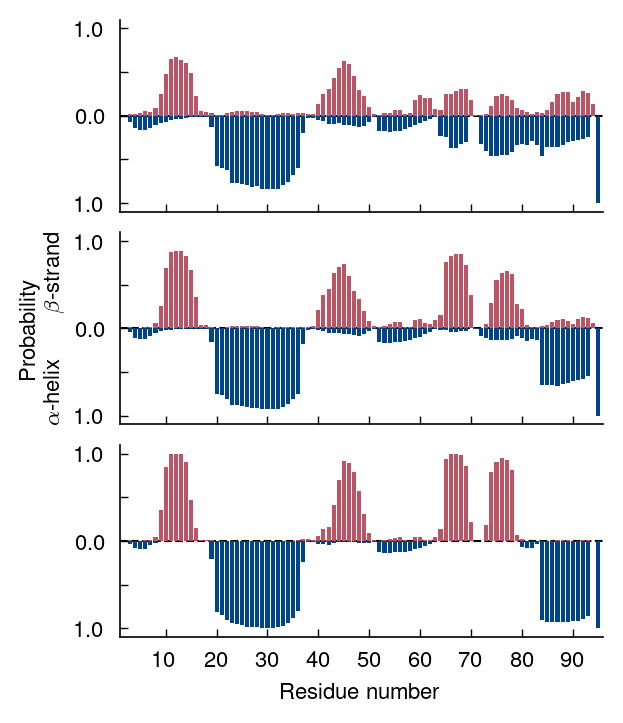

In [162]:
with mpl.style.context("high-contrast"):
    qsliceindex = 1
    fig, axes = plt.subplots(
        3, 1, figsize=(3, 3.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    for ax, qp, dssp in zip(axes.flat, qp_all_ts, dssps_all_ts):
        steps, q_inds = bin_inds(qp, qstep=0.2, low=0, hi=1)
        prob_helix, prob_strand, prob_coil = compute_per_res_prob_ss(
            np.concatenate(dssp)[q_inds[qsliceindex]])
        ax.bar(range(1, len(prob_coil) + 1), -prob_helix, color="C0", align="center")
        ax.bar(range(1, len(prob_coil) + 1), prob_strand, color="C2", align="center")
        ax.set_xlim([0, len(prob_coil) + 1])
        ax.set_ylim([-1.1, 1.1])
        # ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
        ax.set_xlabel("Residue number")
        ax.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
        ax.set_yticks(np.linspace(-1, 1, 5), labels=[1.0, "", 0.0, "", 1.0])

        ax.axhline(0, ls="--", color="k", zorder=0)
        sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
        ax.label_outer()
        # draw_ss(ax, 1.15, -1.15, "gray", "gray", width=0.5, height=0, textoffset=0.2)
    axes[1].set_ylabel("Probability\n$\\alpha$-helix$\qquad\\beta$-strand")
    fig.savefig("../../../dga/figures/dssp_ts_q2-4.pdf", bbox_inches='tight')
    plt.show()

# look at structures

In [36]:
def get_trajfiles(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    traj_files = []
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            listed = glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.h5")
            if len(listed) != 0:
                traj_files.extend(listed)
    return traj_files

In [38]:
all_trajfiles = {}
for t in (87, 89, 91):
    all_trajfiles[t] = get_trajfiles(t)

In [39]:
def load_and_save(t, traj_id):
    trajfile = all_trajfiles[t][traj_id]
    print(trajfile)
    traj = md.load(trajfile)
    traj.save_xtc(os.path.join(os.path.dirname(trajfile), "traj.xtc"))

## near $Q_{core} \approx 0.4$ well

In [40]:
qcore = cvs_all_ts[0]["q_core"]
print(np.argsort(np.mean((qcore - 0.37) ** 2, axis=1))[:10])

[14817 12311 13897 14190 14698 14191 13777 13701 13832 11929]


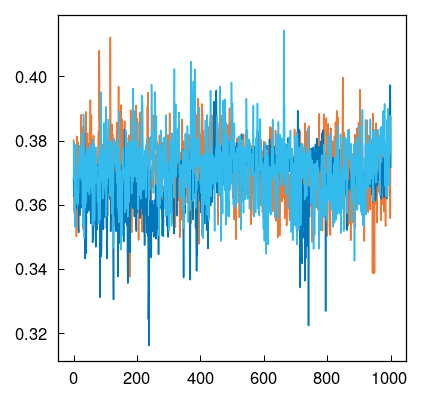

In [42]:
plt.plot(qcore[14817])
plt.plot(qcore[12311])
plt.plot(qcore[13897])
plt.show()

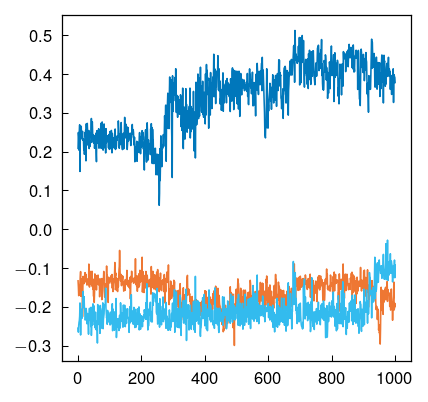

In [43]:
for id in (14817, 12311, 13897):
    plt.plot(cvs_all_ts[0]["q_gs"][id] - cvs_all_ts[0]["q_fs"][id])
plt.show()

In [47]:
traj = md.load(trajfiles[14817])

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [102]:
print(trajfiles[14817])
print(trajfiles[12311])

/project/dinner/scguo/kaiB/dga/new_87/08/08278/cis/rerun_1_18_21.run.h5
/project/dinner/scguo/kaiB/dga/new_87/06/06632/cis/rerun_0_15_07.run.h5


In [49]:
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[14817]), "traj.xtc"))

In [106]:
traj = md.load(trajfiles[12311])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[12311]), "traj.xtc"))

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [49]:
load_and_save(87, 13897)

/project/dinner/scguo/kaiB/dga/new_87/07/07807/trans/rerun_1_03_30.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


## unfolded well ($Q_{core} \approx 0.16)$

In [104]:
qcore = cvs_all_ts[0]["q_core"]
print(np.argsort(np.mean((qcore - 0.16) ** 2, axis=1))[:10])

[17878 21220 18332 11260 18203  4828 21090 21532 18333 18625]


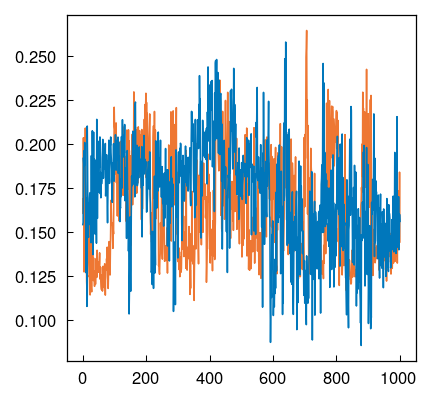

In [105]:
plt.plot(qcore[17878])
plt.plot(qcore[21220])
plt.show()

In [107]:
print(trajfiles[17878])
traj = md.load(trajfiles[17878])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[17878]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_87/09/09812/cis/rerun_2_18_19.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [108]:
print(trajfiles[21220])
traj = md.load(trajfiles[21220])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[21220]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_87/11/11486/cis/rerun_3_22_29.run.h5


In [109]:
qcore = cvs_all_ts[0]["q_core"]
print(np.argsort(np.mean((qcore - 0.08) ** 2, axis=1))[:10])

[ 5743  8264 22227 13625 15946 13245  8582 18460  5793  8255]


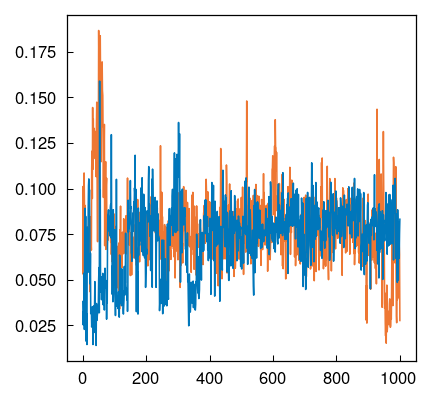

In [110]:
plt.plot(qcore[5743])
plt.plot(qcore[8264])
plt.show()

In [111]:
print(trajfiles[5743])
traj = md.load(trajfiles[5743])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[5743]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_87/02/02929/trans/fs_p2.5_43_16.run.h5


In [112]:
print(trajfiles[8264])
traj = md.load(trajfiles[8264])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[8264]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_87/04/04254/cis/05_31_36_29.run.h5


In [44]:
qcore = cvs_all_ts[2]["q_core"]
print(np.argsort(np.mean((qcore - 0.08) ** 2, axis=1))[:10])

[21542 11836 18619 21915  5162 11361 18649  5821 19505 19724]


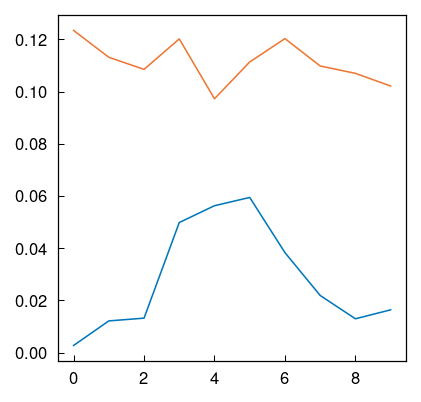

In [48]:
plt.plot(qcore[21542][-10:])
plt.plot(qcore[11836][-10:])
plt.show()

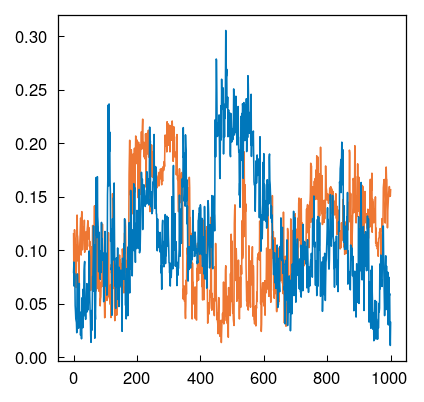

In [46]:
plt.plot(cvs_all_ts[2]['q_gs_all'][21542])
plt.plot(cvs_all_ts[2]['q_gs_all'][11836])
plt.show()

In [163]:
trajfiles = get_trajfiles(91)
print(trajfiles[11836])
traj = md.load(trajfiles[11836])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[11836]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_91/05/05920/cis/06_00_40_31.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [161]:
print(trajfiles[21542])
traj = md.load(trajfiles[21542])
traj.save_xtc(os.path.join(os.path.dirname(trajfiles[21542]), "traj.xtc"))

/project/dinner/scguo/kaiB/dga/new_91/11/11565/trans/rerun_3_25_12.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


## well with $Q_{core} = 0.6$ (near gs)

In [50]:
qcore = cvs_all_ts[0]["q_core"]
print(np.argsort(np.mean((qcore - 0.6) ** 2, axis=1))[:10])

[6663 6070 6664 6683 6071 6386 6153 6822 6069 6492]


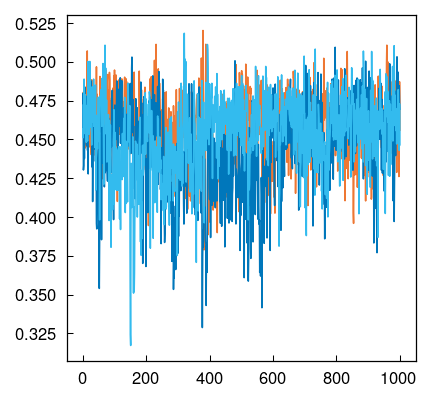

In [51]:
for id in (6663, 6070, 6664):
    plt.plot(cvs_all_ts[0]["q_gs"][id] - cvs_all_ts[0]["q_fs"][id])
plt.show()

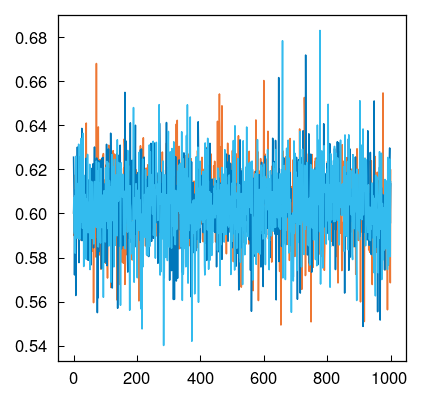

In [52]:
for id in (6663, 6070, 6664):
    plt.plot(qcore[id])
plt.show()

In [53]:
load_and_save(87, 6663)
load_and_save(87, 6070)

/project/dinner/scguo/kaiB/dga/new_87/03/03401/cis/05_31_10_08.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


/project/dinner/scguo/kaiB/dga/new_87/03/03093/cis/05_31_00_20.run.h5


## Well with $Q_{core} \approx 0.5$ near ffs

In [54]:
qcore = cvs_all_ts[0]["q_core"]
print(np.argsort(np.mean((qcore - 0.5) ** 2, axis=1))[:10])

[1210 4365 4154 2983 3368 7242 3279  155 2982 4426]


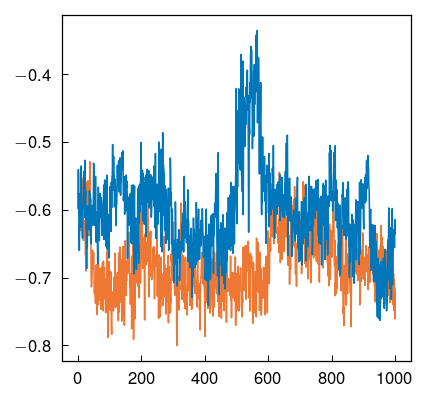

In [58]:
for id in (4365, 4154):
    plt.plot(cvs_all_ts[0]["q_gs"][id] - cvs_all_ts[0]["q_fs"][id])
plt.show()

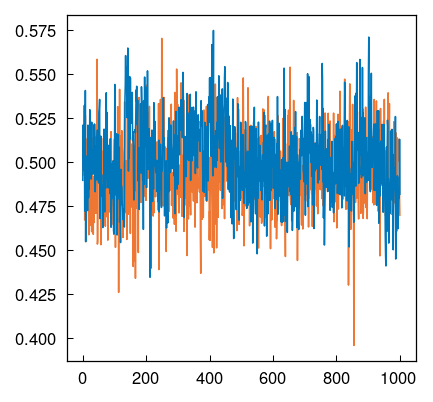

In [59]:
for id in (4365, 4154):
    plt.plot(qcore[id])
plt.show()

In [60]:
load_and_save(87, 4365)
load_and_save(87, 4154)

/project/dinner/scguo/kaiB/dga/new_87/02/02239/trans/fs_p2.5_21_30.run.h5
/project/dinner/scguo/kaiB/dga/new_87/02/02134/cis/fs_p2.5_18_21.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
